In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


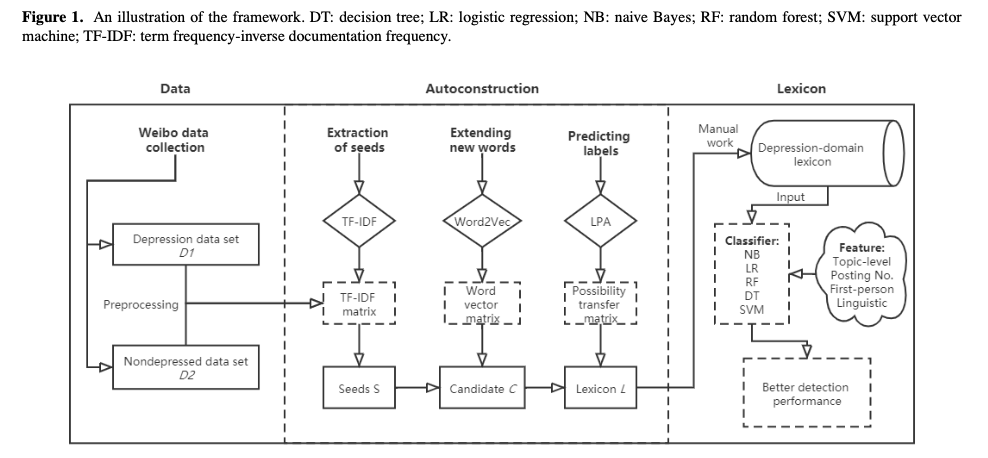

- Data : 우울장애 관련 표현_정리.xlsx 파일 사용 --> 웰니스 데이터로 확장하기
- Multi-Labeling : Data 파일 안에 있는 우울증 증상을 Label로 두기

# 데이터셋

## 1.  웰니스 데이터 불러오기

In [ ]:
import pandas as pd

well_df = pd.read_excel('/content/drive/MyDrive/대학원/project/웰니스_대화_스크립트_데이터셋.xlsx').iloc[:, :2]
well_df

,구분,유저
0,감정/감정조절이상,제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.
1,감정/감정조절이상,더 이상 내 감정을 내가 컨트롤 못 하겠어.
2,감정/감정조절이상,하루종일 오르락내리락 롤러코스터 타는 기분이에요.
3,감정/감정조절이상,꼭 롤러코스터 타는 것 같아요.
4,감정/감정조절이상,롤러코스터 타는 것처럼 기분이 왔다 갔다 해요.
...,...,...
5226,현재상태/증상지속,한숨 자고 일어나면 괜찮으려나? 해서 자고 일어났는데도 똑같아요.
5227,현재상태/증상지속,자고 나면 괜찮을 줄 알았는데 비슷해…
5228,현재상태/증상지속,지금도 상태가 계속 안 좋아.
5229,현재상태/증상지속,이게 제 마음과 상관없이 증상이 계속 나타나요.


## 2. DSM-5 불러오기


In [ ]:
import pandas as pd

dsm_data = pd.read_excel('/content/drive/MyDrive/대학원/project/우울장애 관련 표현_정리.xlsx', sheet_name = None)
dsm_data

{'1. 우울기분':    1. 하루 중 대부분 그리고 거의 매일 지속되는 우울 기분에 대해 주관적으로 보고 (예, 슬픔, 공허하다 또는 절망감) 하거나 객관적으로 관찰됨(예, 눈물흘림)  \
 0                         우울한 기분 (슬픔, 절망감, 무력감, 무가치감)                                          
 1                                              가망이 없다                                          
 2                                              가슴 아프다                                          
 3                                               가치 없다                                          
 4                                             갇힌 것 같다                                          
 5                                                갑갑하다                                          
 6                                               고통스럽다                                          
 7                                                공허하다                                          
 8                                                 괴롭다                                          
 9                 

In [ ]:
dsm_dict = {'우울기분' : [x for x in dsm_data['1. 우울기분'].iloc[:, 0][1:]],
            '흥미_즐거움감소' : [x for x in dsm_data['2. 흥미나 즐거운 감소'].iloc[:, 0]],
            '체중변화' : [x for x in dsm_data['3. 체중변화'].iloc[:, 0]],
            '불면_수면과다' : [x for x in dsm_data['4. 불면,수면과다'].iloc[:, 0][1:]],
            '초조_지연' : [x for x in dsm_data['5. 초조, 지연'].iloc[3:, 0]],
            '피로_활력상실' : [x for x in dsm_data['6. 피로나 활력상실'].iloc[1:, 0]],
            '무가치감_및_죄책감' : [x for x in dsm_data['7. 무가치감 및 죄책감'].iloc[:, 0]],
            '사고력_집중력감소' : [x for x in dsm_data['8. 사고력,집중력감소'].iloc[:, 0]],
            '자살사고' : [x for x in dsm_data['9. 자살사고'].iloc[:, 0]]
}

In [ ]:
dsm_df = pd.DataFrame()

for i in [x for x in dsm_dict.keys()]:
  dsm_ = pd.DataFrame(dsm_dict[f'{i}'], columns = ['word'])
  dsm_['symptom'] = f'{i}'
  dsm_df = pd.concat([dsm_df, dsm_])

dsm_df = dsm_df.reset_index().iloc[:, 1:]
dsm_df

,word,symptom
0,가망이 없다,우울기분
1,가슴 아프다,우울기분
2,가치 없다,우울기분
3,갇힌 것 같다,우울기분
4,갑갑하다,우울기분
...,...,...
358,죽어야 한다,자살사고
359,죽음,자살사고
360,칼빵,자살사고
361,한강에 뛰어들다,자살사고


In [ ]:
dsm_df.groupby(['symptom']).count()

,word
symptom,
무가치감_및_죄책감,45
불면_수면과다,33
사고력_집중력감소,26
우울기분,59
자살사고,48
체중변화,44
초조_지연,37
피로_활력상실,26
흥미_즐거움감소,45


# 데이터셋에서 단어 추출 및 토큰화
- dsm_word, dsm_whole
- okt_tokenized_dsm_word
- okt_whole_tokenized

## 1. dsm_df

### 1. 형태소 분석

In [ ]:
# 형태소 분석기 불러오기
!pip install konlpy

from konlpy.tag import *

hannanum = Hannanum()

# dsm 표현 데이터셋 형태소 분석 후 df 형태로 저장
word_li = []
pos_li = []
label_li = []

for symp in dsm_df.symptom.unique():
  for line in [x for x in dsm_df.query(f"symptom == '{symp}'").word]:
    words = hannanum.pos(line)
    for i in range(len(words)):
      word_li.append(words[i][0])
      pos_li.append(words[i][1])
      label_li.append(symp)

dsm_w_df = pd.DataFrame({'words': word_li, 'pos': pos_li, 'symptoms' : label_li})

# 형태소 N, P 만 남기기
dsm_f_word = dsm_w_df.query("pos == 'N' | pos == 'P'").reset_index().iloc[:, 1:]

# pos 없애서 최종 데이터프레임 만들기
dsm_word = dsm_f_word.loc[:, ['words', 'symptoms']]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
dsm_word

,words,symptoms
0,가망,우울기분
1,없,우울기분
2,가슴,우울기분
3,아프,우울기분
4,가치,우울기분
...,...,...
601,죽음,자살사고
602,칼빵,자살사고
603,한강,자살사고
604,뛰어들,자살사고


In [ ]:
dsm_word.groupby(['symptoms']).count()

,words
symptoms,
무가치감_및_죄책감,76
불면_수면과다,57
사고력_집중력감소,43
우울기분,91
자살사고,98
체중변화,76
초조_지연,51
피로_활력상실,41
흥미_즐거움감소,73


In [ ]:
## 통문장 넣은 데이터셋(비교용)
whole_sents = []
symp_li = []

for i in range(len(dsm_df)):
  if ' ' in dsm_df.iloc[i, 0]:
    whole_sents.append(dsm_df.iloc[i, 0])
    symp_li.append(dsm_df.iloc[i, 1])

whole_df = pd.DataFrame({'words' : whole_sents, 'symptoms' : symp_li})
whole_df

## 단어만 있는 데이터프레임에 추가하기
dsm_whole = dsm_word.copy()
dsm_whole = pd.concat([dsm_word, whole_df])
dsm_whole = dsm_whole.reset_index().iloc[:, 1:]
dsm_whole

,words,symptoms
0,가망,우울기분
1,없,우울기분
2,가슴,우울기분
3,아프,우울기분
4,가치,우울기분
...,...,...
801,죽는 방법,자살사고
802,죽는게 낫다,자살사고
803,죽어도 괜찮다,자살사고
804,죽어야 한다,자살사고


In [ ]:
dsm_whole.groupby(['symptoms']).count()

,words
symptoms,
무가치감_및_죄책감,102
불면_수면과다,83
사고력_집중력감소,57
우울기분,116
자살사고,132
체중변화,103
초조_지연,63
피로_활력상실,51
흥미_즐거움감소,99


## 2. well_df

In [ ]:
# 기호 제외한 문자만 추출
import re

well = [x for x in well_df['유저']]
pp_well = []

for data in well:
  data = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', data)
  pp_well.append(data)
  
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


# 형태소 분석기 OKT를 사용한 토큰화 작업
okt = Okt()

tokenized_data_well = []
for sentence in pp_well:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data_well.append(stopwords_removed_sentence)

tokenized_data_well

[['제',
  '감정',
  '이상하다',
  '것',
  '같다',
  '남편',
  '만',
  '보다',
  '화가',
  '치밀다',
  '오르다',
  '감정',
  '조절',
  '안되다'],
 ['더', '이상', '내', '감정', '을', '내', '컨트롤', '못'],
 ['하루', '종일', '오르락내리락', '롤러코스터', '타다', '기분', '이에요'],
 ['꼭', '롤러코스터', '타다', '것', '같다'],
 ['롤러코스터', '타다', '것', '처럼', '기분', '오다', '가다', '해', '요'],
 ['작년', '가을', '부터', '감정', '조절', '자다', '안', '되다', '거', '같다'],
 ['예전', '비', '인내심', '너무', '짧아지다', '거', '같다'],
 ['더', '이상', '혼자', '서다', '감정', '조절', '을', '못'],
 ['점점', '나', '자신', '을', '컨트롤', '못', '기분', '이야'],
 ['나다', '이르다', '싫다', '내', '마음대로', '안', '돼다'],
 ['맨', '정신', '일', '때', '저', '주체', '수', '가다', '없다'],
 ['주체', '안', '돼다'],
 ['이렇게', '쌓이다', '쌓이다', '나중', '확', '터지다', '진짜', '걷다', '잡', '을', '수', '없다'],
 ['근데', '감정', '을', '다스리다', '못', '욱', '하', '기도', '하고'],
 ['순간', '순간', '감정', '조절', '을', '못'],
 ['평소',
  '다른',
  '일',
  '을',
  '때',
  '비슷하다',
  '생각',
  '대로',
  '안되다',
  '화가',
  '나다',
  '그렇다',
  '상황',
  '지속',
  '되다',
  '폭발',
  '버리다'],
 ['예전', '보다', '화', '내다', '게', '과격하다', '거', '같다'],
 ['화가', '안', '참다

## 3. 최종

In [ ]:
### 최종
tokenized_data_dsm_word = []
tokenized_label_li = []


for symp in dsm_df.symptom.unique():
  for line in [x for x in dsm_df.query(f"symptom == '{symp}'").word]:
    # 기호 제거
    data = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', line)
    
    # 불용어 정의
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

    # 형태소 분석기 OKT를 사용한 토큰화 작업
    okt = Okt() 

    tokenized_sentence = okt.morphs(line, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data_dsm_word.append(stopwords_removed_sentence)
    tokenized_label_li.append(symp)

okt_tokenized_dsm_word = pd.DataFrame({'words': tokenized_data_dsm_word, 'symptoms': tokenized_label_li})
okt_tokenized_dsm_word

,words,symptoms
0,"[가망, 없다]",우울기분
1,"[가슴, 아프다]",우울기분
2,"[가치, 없다]",우울기분
3,"[갇히다, 것, 같다]",우울기분
4,[갑갑하다],우울기분
...,...,...
358,[죽다],자살사고
359,[죽음],자살사고
360,[칼빵],자살사고
361,"[한강, 뛰어들다]",자살사고


In [ ]:
okt_whole_tokenized = okt_tokenized_dsm_word.copy()

## 통문장 넣은 데이터셋(비교용)
whole_sents = []
symp_li = []

for i in range(len(dsm_df)):
  if ' ' in dsm_df.iloc[i, 0]:
    whole_sents.append(dsm_df.iloc[i, 0])
    symp_li.append(dsm_df.iloc[i, 1])

whole_df = pd.DataFrame({'words' : whole_sents, 'symptoms' : symp_li})

# 띄어쓰기로만 단어 구분
splited_words = []

for word in whole_df['words']:
  splited_words.append(word.split(" "))

splited_words

,words,symptoms
0,가망이 없다,우울기분
1,가슴 아프다,우울기분
2,가치 없다,우울기분
3,갇힌 것 같다,우울기분
4,기대할 것이 없다,우울기분
...,...,...
195,죽는 방법,자살사고
196,죽는게 낫다,자살사고
197,죽어도 괜찮다,자살사고
198,죽어야 한다,자살사고


In [ ]:
whole_df['words'] = splited_words
whole_df

,words,symptoms
0,"[가망이, 없다]",우울기분
1,"[가슴, 아프다]",우울기분
2,"[가치, 없다]",우울기분
3,"[갇힌, 것, 같다]",우울기분
4,"[기대할, 것이, 없다]",우울기분
...,...,...
195,"[죽는, 방법]",자살사고
196,"[죽는게, 낫다]",자살사고
197,"[죽어도, 괜찮다]",자살사고
198,"[죽어야, 한다]",자살사고


In [ ]:
okt_whole_tokenized = okt_tokenized_dsm_word.copy()

okt_whole_tokenized = pd.concat([okt_whole_tokenized, whole_df])
okt_whole_tokenized = okt_whole_tokenized.reset_index().iloc[:, 1:]

In [ ]:
okt_whole_tokenized

,words,symptoms
0,"[가망, 없다]",우울기분
1,"[가슴, 아프다]",우울기분
2,"[가치, 없다]",우울기분
3,"[갇히다, 것, 같다]",우울기분
4,[갑갑하다],우울기분
...,...,...
558,"[죽는, 방법]",자살사고
559,"[죽는게, 낫다]",자살사고
560,"[죽어도, 괜찮다]",자살사고
561,"[죽어야, 한다]",자살사고


## 4. Manual수정해서 최종 데이터셋 만들기

In [ ]:
okt_tokenized_dsm_word['words'][351] = ['자살', '충동']

In [ ]:
[x for x in okt_tokenized_dsm_word['words']][350:]

[['자살', '방법'],
 ['자살', '충동'],
 ['자해'],
 ['잠', '에서', '깨지다', '않다'],
 ['죽다'],
 ['죽다', '방법'],
 ['죽다', '낫다'],
 ['죽다', '괜찮다'],
 ['죽다'],
 ['죽음'],
 ['칼빵'],
 ['한강', '뛰어들다'],
 ['현실', '도피']]

In [ ]:
[x for x in okt_tokenized_dsm_word['words']][351]

['자살', '충', '동']

# Extending New Words With W2V
- W2V, 코사인 유사도 사용

W2V 후, 코사인 유사도 구하기

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# dsm_word
model_word = Word2Vec(sentences = [x for x in okt_tokenized_dsm_word.words], window = 5, min_count = 1, workers = 4, sg = 0)
model_well = Word2Vec(sentences = tokenized_data_well, window = 5, min_count = 2, workers = 4, sg = 0)

word_candi_li = []

for word in [x for x in model_word.wv.key_to_index]:
  for well_word in [x for x in model_well.wv.key_to_index]:
    similarity = cosine_similarity([model_word.wv[word]], [model_well.wv[well_word]])

    if similarity >= 0:
      word_candi_li.append(well_word)

word_candi_li

['을',
 '있다',
 '같다',
 '것',
 '안',
 '없다',
 '거',
 '그렇다',
 '내',
 '자다',
 '때',
 '너무',
 '못',
 '생각',
 '싶다',
 '나',
 '되다',
 '그',
 '아니다',
 '들다',
 '게',
 '보다',
 '다',
 '사람',
 '않다',
 '근데',
 '돼다',
 '에서',
 '저',
 '가다',
 '좋다',
 '그냥',
 '만',
 '제',
 '먹다',
 '진짜',
 '일',
 '오다',
 '말',
 '부터',
 '로',
 '그래서',
 '계속',
 '하고',
 '고',
 '남편',
 '더',
 '모르다',
 '많이',
 '잠',
 '요',
 '한테',
 '받다',
 '나다',
 '전',
 '힘들다',
 '요즘',
 '거야',
 '집',
 '죽다',
 '이다',
 '왜',
 '건',
 '아무',
 '니까',
 '수',
 '많다',
 '싫다',
 '번',
 '정도',
 '이렇게',
 '해',
 '적',
 '살다',
 '예요',
 '걱정',
 '에는',
 '다니다',
 '마음',
 '엄청',
 '기분',
 '어떻다',
 '지금',
 '친구',
 '불안하다',
 '그렇게',
 '알다',
 '또',
 '일이',
 '정말',
 '애',
 '막',
 '하루',
 '괜찮다',
 '문제',
 '날',
 '뭐',
 '랑',
 '아프다',
 '이렇다',
 '살',
 '다른',
 '뭔가',
 '걸',
 '병원',
 '술',
 '까지',
 '회사',
 '하나',
 '우울하다',
 '자꾸',
 '느낌',
 '학교',
 '몸',
 '이야',
 '처음',
 '돈',
 '나오다',
 '엄마',
 '이랑',
 '그래도',
 '말다',
 '처럼',
 '원래',
 '라고',
 '때문',
 '인',
 '나가다',
 '버리다',
 '머리',
 '되게',
 '소리',
 '다시',
 '그게',
 '갑자기',
 '이상하다',
 '시간',
 '혼자',
 '같이',
 '떨어지다',
 '면',
 '뭘',
 '아빠',
 '그런데',
 '가슴',
 '

In [ ]:
# dsm_whole

model_whole = Word2Vec(sentences = [x for x in okt_whole_tokenized.words], window = 5, min_count = 1, workers = 4, sg = 0)
model_well = Word2Vec(sentences = tokenized_data_well, window = 5, min_count = 2, workers = 4, sg = 0)

whole_candi_li = []

for word in [x for x in model_whole.wv.key_to_index]:
  for well_word in [x for x in model_well.wv.key_to_index]:
    similarity = cosine_similarity([model_whole.wv[word]], [model_well.wv[well_word]])

    if similarity >= 0:
      whole_candi_li.append(well_word)

whole_candi_li

['을',
 '있다',
 '같다',
 '것',
 '안',
 '없다',
 '거',
 '그렇다',
 '내',
 '자다',
 '때',
 '너무',
 '못',
 '생각',
 '싶다',
 '나',
 '되다',
 '그',
 '아니다',
 '들다',
 '게',
 '보다',
 '다',
 '사람',
 '않다',
 '근데',
 '돼다',
 '에서',
 '저',
 '가다',
 '좋다',
 '그냥',
 '만',
 '제',
 '먹다',
 '진짜',
 '일',
 '오다',
 '말',
 '부터',
 '로',
 '그래서',
 '계속',
 '하고',
 '고',
 '남편',
 '더',
 '모르다',
 '많이',
 '잠',
 '요',
 '한테',
 '받다',
 '나다',
 '전',
 '힘들다',
 '요즘',
 '거야',
 '집',
 '죽다',
 '이다',
 '왜',
 '건',
 '아무',
 '니까',
 '수',
 '많다',
 '싫다',
 '번',
 '정도',
 '이렇게',
 '해',
 '적',
 '살다',
 '예요',
 '걱정',
 '에는',
 '다니다',
 '마음',
 '엄청',
 '기분',
 '어떻다',
 '지금',
 '친구',
 '불안하다',
 '그렇게',
 '알다',
 '또',
 '일이',
 '정말',
 '애',
 '막',
 '하루',
 '괜찮다',
 '문제',
 '날',
 '뭐',
 '랑',
 '아프다',
 '이렇다',
 '살',
 '다른',
 '뭔가',
 '걸',
 '병원',
 '술',
 '까지',
 '회사',
 '하나',
 '우울하다',
 '자꾸',
 '느낌',
 '학교',
 '몸',
 '이야',
 '처음',
 '돈',
 '나오다',
 '엄마',
 '이랑',
 '그래도',
 '말다',
 '처럼',
 '원래',
 '라고',
 '때문',
 '인',
 '나가다',
 '버리다',
 '머리',
 '되게',
 '소리',
 '다시',
 '그게',
 '갑자기',
 '이상하다',
 '시간',
 '혼자',
 '같이',
 '떨어지다',
 '면',
 '뭘',
 '아빠',
 '그런데',
 '가슴',
 '

In [ ]:
print(len(word_candi_li))
len(whole_candi_li)

624616


862231

# W2V + LPA

## 1. okt_tokenized_dsm_word + word_candi_li

### 1.1 데이터 전처리

In [ ]:
import pandas as pd

okt_tokenized_dsm_word = pd.read_csv('/content/drive/MyDrive/대학원/project/final_okt_tokenized_dsm_word.csv').iloc[:, 1:]
okt_tokenized_dsm_word

,words,symptoms
0,"['가망', '없다']",우울기분
1,"['가슴', '아프다']",우울기분
2,"['가치', '없다']",우울기분
3,"['갇히다', '것', '같다']",우울기분
4,['갑갑하다'],우울기분
...,...,...
358,['죽다'],자살사고
359,['죽음'],자살사고
360,['칼빵'],자살사고
361,"['한강', '뛰어들다']",자살사고


In [ ]:
# 웰니스 데이터 후보 단어들만 추출
word_final_well = []

for line in tokenized_data_well:
  add_line = []

  for words in line:
    if words in word_candi_li:
      add_line.append(words)
  
  word_final_well.append(add_line)

# okt_tokenized_dsm_word + well
add_well = pd.DataFrame({'words': word_final_well, 'symptoms' : '웰니스'})
dsm_word_well = pd.concat([okt_tokenized_dsm_word, add_well]).reset_index().iloc[:, 1:]
dsm_word_well

In [ ]:
label_list = []

for i in range(len(dsm_word_well)):
  if dsm_word_well.iloc[i, 1] == '우울기분':
    label_list.append(0)
  elif dsm_word_well.iloc[i, 1] == '흥미_즐거움감소':
    label_list.append(1)
  elif dsm_word_well.iloc[i, 1] == '체중변화':
    label_list.append(2)
  elif dsm_word_well.iloc[i, 1] == '불면_수면과다':
    label_list.append(3)
  elif dsm_word_well.iloc[i, 1] == '초조_지연':
    label_list.append(4)
  elif dsm_word_well.iloc[i, 1] == '피로_활력상실':
    label_list.append(5)
  elif dsm_word_well.iloc[i, 1] == '무가치감_및_죄책감':
    label_list.append(6)
  elif dsm_word_well.iloc[i, 1] == '사고력_집중력감소':
    label_list.append(7)
  elif dsm_word_well.iloc[i, 1] == '자살사고':
    label_list.append(8)
  else:
    label_list.append(-1)

dsm_word_well['label'] = label_list
dsm_word_well

,words,symptoms,label
0,"['가망', '없다']",우울기분,0
1,"['가슴', '아프다']",우울기분,0
2,"['가치', '없다']",우울기분,0
3,"['갇히다', '것', '같다']",우울기분,0
4,['갑갑하다'],우울기분,0
...,...,...,...
5589,"['한숨', '자고', '일어나다', '괜찮다', '자고', '일어나다', '똑같다']",웰니스,-1
5590,"['자고', '나다', '괜찮다', '줄', '알다', '비슷하다']",웰니스,-1
5591,"['지금', '상태', '계속', '안', '좋다']",웰니스,-1
5592,"['게', '제', '마음', '상관없다', '증상', '계속', '나타나다']",웰니스,-1


### 1.2 모델 만들기

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
import re

# 레이블 dict 만들기
label_dict_li = []


# 데이터 프레임 안에 있는 리스트 str에서 다시 복구하기
word_well = []

for i in range(len(dsm_word_well)):
  str_list = dsm_word_well.iloc[i, 0].split("'")
  real_str_list = []

  for strs in str_list:
    if re.search('[가-힣]+', strs):
      real_str_list.append(strs)
  
  word_well.append(real_str_list)

# 복구한 리스트로 레이블 딕셔너리 만들기
for i in range(len(word_well)):
  words_ = word_well[i]
  symp = dsm_word_well.loc[i, 'label']

  for word in words_:
    dict_to_add = {}
    dict_to_add[word] = symp
    label_dict_li.append(dict_to_add)

label_dict_li

[{'가망': 0},
 {'없다': 0},
 {'가슴': 0},
 {'아프다': 0},
 {'가치': 0},
 {'없다': 0},
 {'갇히다': 0},
 {'것': 0},
 {'같다': 0},
 {'갑갑하다': 0},
 {'고통스럽다': 0},
 {'공허하다': 0},
 {'괴롭다': 0},
 {'기대하다': 0},
 {'것': 0},
 {'없다': 0},
 {'기분': 0},
 {'가라앉다': 0},
 {'기분': 0},
 {'나쁘다': 0},
 {'기분': 0},
 {'별로': 0},
 {'다': 0},
 {'기분': 0},
 {'안좋다': 0},
 {'기분': 0},
 {'처지다': 0},
 {'꿀꿀하다': 0},
 {'끔찍하다': 0},
 {'끝장': 0},
 {'나락': 0},
 {'눈물': 0},
 {'단념': 0},
 {'답답하다': 0},
 {'더': 0},
 {'내려가다': 0},
 {'데': 0},
 {'없다': 0},
 {'마음': 0},
 {'아프다': 0},
 {'막': 0},
 {'다른': 0},
 {'느낌': 0},
 {'막막하다': 0},
 {'망하다': 0},
 {'무의미하다': 0},
 {'바닥': 0},
 {'까지': 0},
 {'내려가다': 0},
 {'방법': 0},
 {'없다': 0},
 {'방향': 0},
 {'을': 0},
 {'잃다': 0},
 {'부질없다': 0},
 {'불편': 0},
 {'불행': 0},
 {'비참': 0},
 {'살기': 0},
 {'싫다': 0},
 {'생각': 0},
 {'싫다': 0},
 {'센치하다': 0},
 {'속상하다': 0},
 {'슬프다': 0},
 {'실패': 0},
 {'앞': 0},
 {'캄캄하다': 0},
 {'외롭다': 0},
 {'우울하다': 0},
 {'울다': 0},
 {'울적하다': 0},
 {'이생망': 0},
 {'저주받다': 0},
 {'절망': 0},
 {'좌절': 0},
 {'죽다': 0},
 {'싶다': 0},
 {'죽다': 0},
 {'맛': 0}

In [ ]:
# Word2Vec
model_dsm_word_well = Word2Vec(word_well, min_count=1, workers=4)
model_dsm_word_well.init_sims(replace=True)

<ipython-input-10-b1985c3198bc>:3: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model_dsm_word_well.init_sims(replace=True)


### 1.3 dsm만 우선 그래프 만들기

In [ ]:
dsm_word_well

,words,symptoms,label
0,"['가망', '없다']",우울기분,0
1,"['가슴', '아프다']",우울기분,0
2,"['가치', '없다']",우울기분,0
3,"['갇히다', '것', '같다']",우울기분,0
4,['갑갑하다'],우울기분,0
...,...,...,...
5589,"['한숨', '자고', '일어나다', '괜찮다', '자고', '일어나다', '똑같다']",웰니스,-1
5590,"['자고', '나다', '괜찮다', '줄', '알다', '비슷하다']",웰니스,-1
5591,"['지금', '상태', '계속', '안', '좋다']",웰니스,-1
5592,"['게', '제', '마음', '상관없다', '증상', '계속', '나타나다']",웰니스,-1


In [ ]:
import pandas as pd
import re
import numpy as np

G_df = pd.DataFrame()

# 우울장애 symptom 9개 별로 그래프 노드 및 엣지 생성
for l in range(9):
  # 한 개의 symptom 별로 보기
  dsm_w = dsm_word_well.query(f"label == {l}")
    
  # 데이터 프레임 안에 있는 리스트 str에서 다시 list로 복구하기
  d_w_list = []

  for i in range(len(dsm_w)):
    str_list = dsm_w.iloc[i, 0].split("'")
    real_str_list = []

    for strs in str_list:
      if re.search('[가-힣]+', strs):
        real_str_list.append(strs)
    
    d_w_list.append(real_str_list)

  # 한 문장으로 묶인 단어들 각각으로 풀기(indexing을 위한 word 리스트 만들기)
  word_list_ = []

  for k in range(len(d_w_list)):
    lines = d_w_list[k]
    for u in range(len(lines)):
      word_list_.append(lines[u])

  # 그래프 그리기 위한 데이터프레임 만들기
  # 유사도를 통해 노드와 엣지 만들기
  word_from = []
  word_to = []
  weight = []

  for word1 in word_list_:
      for word2 in word_list_:
          if word1 != word2:
              similarity = model_dsm_word_well.wv.similarity(word1, word2)
              if similarity > 0.8:
                word_from.append(model_dsm_word_well.wv.key_to_index[f'{word1}'])
                word_to.append(model_dsm_word_well.wv.key_to_index[f'{word2}'])
                weight.append(similarity)

  # 데이터프레임 추가하기
  df_to_add = pd.DataFrame({'word_from' : word_from, 'word_to' : word_to, 'weight' : weight})
  
  G_df = pd.concat([G_df, df_to_add])

G_df = G_df.reset_index()
G_df = G_df.iloc[:, 1:]
G_df

,word_from,word_to,weight
0,5,144,0.999303
1,5,94,0.999396
2,5,975,0.954458
3,5,731,0.996213
4,5,4,0.999296
...,...,...,...
35107,1082,430,0.969159
35108,1082,56,0.970417
35109,1082,92,0.970836
35110,1082,56,0.970417


In [ ]:
import pandas as pd
import re
import numpy as np

G_df = pd.DataFrame()

# 우울장애 symptom 9개 별로 그래프 노드 및 엣지 생성
for l in list(dsm_word_well['symptoms'].unique())[:-1]:
  # 한 개의 symptom 별로 보기
  dsm_w = dsm_word_well.query(f"symptoms == '{l}'")
    
  # 데이터 프레임 안에 있는 리스트 str에서 다시 list로 복구하기
  d_w_list = []

  for i in range(len(dsm_w)):
    str_list = dsm_w.iloc[i, 0].split("'")
    real_str_list = []

    for strs in str_list:
      if re.search('[가-힣]+', strs):
        real_str_list.append(strs)
    
    d_w_list.append(real_str_list)

  # 한 문장으로 묶인 단어들 각각으로 풀기(indexing을 위한 word 리스트 만들기)
  word_list_ = []

  for k in range(len(d_w_list)):
    lines = d_w_list[k]
    for u in range(len(lines)):
      word_list_.append(lines[u])

  # 그래프 그리기 위한 데이터프레임 만들기
  # 유사도를 통해 노드와 엣지 만들기
  word_from = []
  word_to = []
  label_name = []
  weight = []

  for word1 in word_list_:
      for word2 in word_list_:
          if word1 != word2:
              weight.append(1)
              label_name.append(l)
              word_from.append(model_dsm_word_well.wv.key_to_index[f'{word1}'])
              word_to.append(model_dsm_word_well.wv.key_to_index[f'{word2}'])

  # 데이터프레임 추가하기
  df_to_add = pd.DataFrame({'word_from' : word_from, 'word_to' : word_to,
                            'labels' : label_name, 'weight' : weight})
  df_to_add.drop_duplicates(subset = ['word_from', 'word_to'])
  
  G_df = pd.concat([G_df, df_to_add])

G_df = G_df.reset_index()
G_df = G_df.iloc[:, 1:]
G_df

,word_from,word_to,labels,weight
0,2271,5,우울기분,1
1,2271,144,우울기분,1
2,2271,94,우울기분,1
3,2271,975,우울기분,1
4,2271,5,우울기분,1
...,...,...,...,...
54821,2405,2408,자살사고,1
54822,2405,2407,자살사고,1
54823,2405,2406,자살사고,1
54824,2405,1506,자살사고,1


In [ ]:
G_df = G_df.drop_duplicates().reset_index().iloc[:, 1:]
G_df

,word_from,word_to,labels,weight
0,2271,5,우울기분,1
1,2271,144,우울기분,1
2,2271,94,우울기분,1
3,2271,975,우울기분,1
4,2271,731,우울기분,1
...,...,...,...,...
30125,2405,2408,자살사고,1
30126,2405,2407,자살사고,1
30127,2405,2406,자살사고,1
30128,2405,1506,자살사고,1


In [ ]:
# 노드 리스트 만들기
nodes_li = []

for i in range(2):
  for j in G_df.iloc[:, i]:
    nodes_li.append(j)

len(list(set(nodes_li)))

405

In [ ]:
# 노드 만들기
import networkx as nx

G = nx.Graph()
G.add_nodes_from(list(set(nodes_li)))

In [ ]:
# 엣지 리스트 및 가중치
edge_list = []

from_edge = list(G_df.iloc[:, 0])
to_li = list(G_df.iloc[:, 1])

for pair in zip(from_edge, to_li):
  edge_list.append(pair)

edge_list[:5]

[(2271, 5), (2271, 144), (2271, 94), (2271, 975), (2271, 731)]

In [ ]:
# 엣지 추가
G.add_edges_from(edge_list, weight = 1)

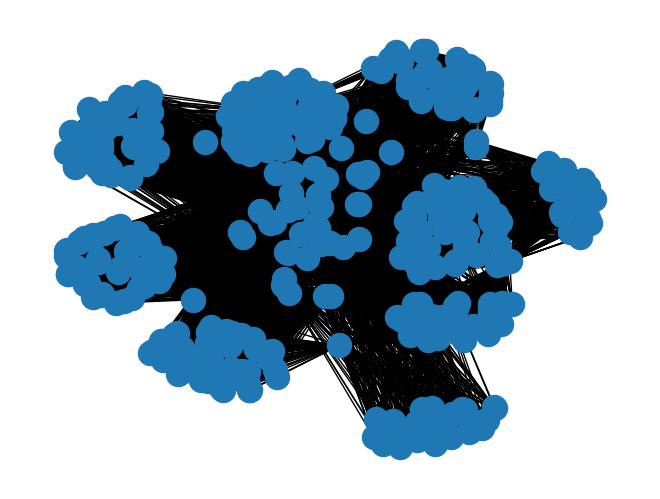

In [ ]:
nx.draw(G)

### 1.4 dsm으로 커뮤니티 나누기

In [ ]:
### 후보 4 ###
### modularity를 평가지표로 두면 될 것 같음
# '우울기분', '흥미_즐거움감소', '체중변화', '불면_수면과다', '초조_지연', '피로_활력상실', '무가치감_및_죄책감', '사고력_집중력감소', '자살사고'

import networkx as nx
from networkx.algorithms import community

communities_initial = community.asyn_fluidc(G, 9, max_iter=100, seed=None)

# 결과 출력
for i, community in enumerate(communities):
    # print(f"Community {i}: {community}")
    
    words_list = []

    for word in community:
      str_word = model_dsm_word_well.wv.index_to_key[word]
      words_list.append(str_word)
    
    print(f"Community {i} : ", words_list)

Community 0 :  ['을', '거', '자다', '공황', '꼼지락', '짜증', '땀', '식다', '비디오', '슬로우', '보스', '멎다', '초조', '불길', '차다', '느리다', '말수', '숨', '느릿느릿', '말', '날카롭다', '린다', '무섭다', '신경질', '두근거리다', '안절부절', '혼란', '불안', '신경', '두렵다', '걱정', '멍하다', '한숨', '마주치다', '가만있다', '어둔하다', '예민', '무겁다', '떨리다', '나무늘보', '떨다', '쓰이다', '나오다', '둔하다', '긴장']
Community 1 :  ['안되다', '실망', '나약하다', '쭈구리', '내', '찌질하다', '그렇다', '찐따', '용서', '못', '밉다', '증오', '무쓸모', '되다', '사람', '자존심', '자기', '쓰레기', '화', '헛', '에게', '벌', '나르다', '미움', '쓸모없다', '나다', '잘못', '받다', '스럽다', '이다', '자신', '왜', '상하다', '업보', '열등감', '탓', '자괴감', '비하', '자기혐오', '싫어하다', '패배', '자책', '자초', '자학', '짓다', '죄송하다', '당하다', '보기', '죄책감', '처지다', '꼴', '죄', '그러면', '미안하다', '뒤', '무시', '한심하다', '때문']
Community 2 :  ['싶다', '나', '손목', '목', '편하다', '내일', '벗어나다', '에서', '만', '지치다', '먹다', '자해', '없어지다', '잠', '이유', '죽다', '곳', '현실', '희망이', '번', '살다', '뜨다', '살기', '오지', '담배빵', '목숨', '끈', '괜찮다', '매달다', '마렵다', '아프다', '끊다', '뭐', '살', '도피', '한강', '칼빵', '죽음', '깨지다', '충동', '하나', '유서', '법', '끝내다', '개탄', '높다', '떨어지다', 

### 1.4 웰니스 데이터 추가해 커뮤니티 나누기

In [ ]:
dsm_word_well.query("label == -1")

,words,symptoms,label
363,"['제', '감정', '이상하다', '것', '같다', '남편', '만', '보다'...",웰니스,-1
364,"['더', '이상', '내', '감정', '을', '내', '컨트롤', '못']",웰니스,-1
365,"['하루', '종일', '롤러코스터', '타다', '기분', '이에요']",웰니스,-1
366,"['꼭', '롤러코스터', '타다', '것', '같다']",웰니스,-1
367,"['롤러코스터', '타다', '것', '처럼', '기분', '오다', '가다', '...",웰니스,-1
...,...,...,...
5589,"['한숨', '자고', '일어나다', '괜찮다', '자고', '일어나다', '똑같다']",웰니스,-1
5590,"['자고', '나다', '괜찮다', '줄', '알다', '비슷하다']",웰니스,-1
5591,"['지금', '상태', '계속', '안', '좋다']",웰니스,-1
5592,"['게', '제', '마음', '상관없다', '증상', '계속', '나타나다']",웰니스,-1


In [ ]:
# 데이터프레임의 데이터 리스트 형태로 다시 바꾸기
only_well_df = dsm_word_well.query("label == -1").reset_index().iloc[:, 1:]

well = []

for i in range(len(only_well_df)):
  str_list = only_well_df.iloc[i, 0].split("'")
  real_str_list = []

  for strs in str_list:
    if re.search('[가-힣]+', strs):
      real_str_list.append(strs)
  
  well.append(real_str_list)

# 리스트에서 다시 단어 뽑아오기
well_list_ = []

for k in range(len(well)):
  lines = well[k]
  for u in range(len(lines)):
    well_list_.append(lines[u])

# 노드 리스트와 가중치 리스트 만들기
well_word_from = []
well_word_to = []
well_weight = []

similarities_list = []

for word1 in well_list_:
    for word2 in word_list_:
            similarity = model_dsm_word_well.wv.similarity(word1, word2)
            similarities_list.append(similarity)

            if similarity > 0.9:
              well_word_from.append(model_dsm_word_well.wv.key_to_index[f'{word1}'])
              well_word_to.append(model_dsm_word_well.wv.key_to_index[f'{word2}'])
              well_weight.append(similarity)

G_to_add = pd.DataFrame({'word_from' : well_word_from, 'word_to' : well_word_to, 'weight' : well_weight})
G_to_add

,word_from,word_to,weight
0,34,504,0.994873
1,34,557,0.987346
2,34,911,0.992750
3,34,27,0.999742
4,34,538,0.994559
...,...,...,...
4133215,8,56,0.999337
4133216,8,92,0.999673
4133217,8,56,0.999337
4133218,8,1506,0.980730


(array([1.82000e+02, 8.00000e+00, 6.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00, 4.00000e+00,
        2.00000e+00, 0.00000e+00, 2.00000e+00, 4.00000e+00, 2.00000e+00,
        0.00000e+00, 4.00000e+00, 2.60000e+01, 1.66000e+02, 8.00000e+00,
        1.82000e+02, 4.40000e+01, 1.68000e+02, 3.20000e+01, 3.90000e+01,
        6.50000e+01, 2.34000e+02, 7.39000e+02, 6.02200e+03, 7.66820e+04,
        3.99670e+04, 3.75800e+03, 2.26300e+03, 6.30190e+04, 1.89170e+04,
        1.10500e+03, 3.28000e+02, 1.46000e+02, 2.11000e+02, 7.30000e+01,
        3.80000e+01, 3.90000e+01, 6.40000e+01, 2.42000e+02, 9.20000e+01,
        1.44000e+02, 5.13000e+02, 8.23000e+02, 1.53000e+03, 3.80920e+04,
        3.02200e+03, 1.39800e+03, 3.48330e+04, 6.50300e+03, 6.75000e+02,
        2.65000e+02, 4.37000e+02, 1.01900e+03, 1.61900e+03, 3.10500e+03,
        4.34980e+04, 7.65430e+04, 7.26500e+03, 1.92060e+04, 6.72980e+04,
        4.22590e+04, 4.41980e+04, 4.04670e+04, 2.12

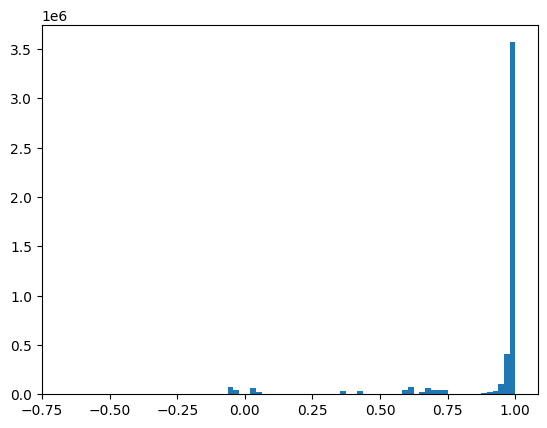

In [ ]:
# threshold 설정 위한 히스토그램
plt.hist(similarities_list, bins = 80)

In [ ]:
G_to_add.drop_duplicates(inplace = True)
G_to_add.reset_index(inplace = True)
G_to_add = G_to_add.iloc[:, 1:]
G_to_add

,word_from,word_to,weight
0,34,504,0.994873
1,34,557,0.987346
2,34,911,0.992750
3,34,27,0.999742
4,34,538,0.994559
...,...,...,...
122873,2130,48,0.916428
122874,2130,430,0.919032
122875,2130,92,0.919150
122876,2130,1506,0.903105


In [ ]:
# 노드 리스트 만들기
well_nodes_li = []

for i in range(2):
  for j in G_to_add.iloc[:, i]:
    well_nodes_li.append(j)

len(list(set(well_nodes_li)))

2190

In [ ]:
# 노드 만들기
G.add_nodes_from(list(set(well_nodes_li)))

In [ ]:
# 엣지 리스트 및 가중치
for i in range(len(G_to_add)):
  from_edge = G_to_add.iloc[i, 0].item()
  to_edge = G_to_add.iloc[i, 1].item()
  weight_ = G_to_add.iloc[i, 2].item()


  G.add_edge(from_edge, to_edge, weight = weight_)

In [ ]:
nx.draw(G)

In [ ]:
G_added = G_df.iloc[:, [0, 1, 3]]
G_added = pd.concat([G_added, G_to_add])
G_added = G_added.drop_duplicates()
G_added

,word_from,word_to,weight
0,2271,5,1.000000
1,2271,144,1.000000
2,2271,94,1.000000
3,2271,975,1.000000
4,2271,731,1.000000
...,...,...,...
122427,2130,48,0.916447
122428,2130,430,0.918409
122429,2130,92,0.918720
122430,2130,1506,0.902573


In [ ]:
import networkx as nx
from networkx.algorithms import community

final_communities = community.asyn_fluidc(G, 9, max_iter=100, seed=None)


# 결과 출력
for i, community in enumerate(final_communities):
    globals()[f'community_{i}'] = community
    print(f"Community {i}: {community}")

Community 0: {2055, 11, 17, 25, 2080, 33, 35, 40, 41, 2094, 46, 2099, 54, 2102, 2110, 2112, 72, 2121, 74, 2124, 81, 2131, 91, 96, 97, 103, 2152, 2154, 2160, 115, 116, 132, 138, 2191, 146, 150, 2203, 2206, 159, 169, 2218, 2226, 2227, 2235, 194, 2242, 2243, 2246, 198, 2255, 209, 212, 213, 217, 2274, 2276, 237, 245, 250, 251, 252, 2304, 257, 262, 263, 2315, 2319, 280, 281, 2329, 283, 2332, 2337, 2344, 300, 2349, 304, 306, 312, 314, 317, 320, 321, 2371, 324, 2372, 330, 332, 2382, 339, 2389, 346, 347, 348, 2397, 2398, 354, 355, 2405, 2406, 360, 361, 369, 372, 2424, 377, 385, 390, 396, 397, 401, 409, 418, 423, 426, 427, 440, 441, 446, 460, 461, 462, 467, 475, 485, 488, 492, 497, 501, 503, 509, 519, 525, 531, 540, 543, 548, 550, 560, 565, 586, 592, 601, 613, 624, 627, 628, 634, 635, 638, 644, 648, 651, 657, 658, 663, 668, 679, 691, 697, 703, 709, 714, 717, 720, 723, 724, 735, 740, 741, 742, 746, 752, 757, 765, 768, 769, 777, 787, 791, 810, 816, 818, 821, 825, 826, 829, 840, 846, 849, 857, 860

### 1.6 community 추정하기

In [ ]:
word_commu = {}

for i in range(9):
  words_list = []

  for word in globals()[f'community_{i}']:
    str_word = model_dsm_word_well.wv.index_to_key[word]
    words_list.append(str_word)

  word_commu[f'community_{i}'] = words_list
  print(f'community_{i} : ', words_list)

community_0 :  ['등록', '너무', '그', '근데', '타고', '먹다', '진짜', '로', '그래서', '신용', '남편', '어찌나', '한테', '그동안', '비참하다', '매번', '이렇게', '허공', '예요', '2일', '어떻다', '터', '애', '문제', '뭐', '뭔가', '창', '마비', '똑', '처음', '돈', '되게', '시간', '왈칵', '대학', '이상', '집안일', '만해', '보', '누가', '허다', '해소', '홱', '입시', '크다', '축하', '엉', '학력', '해보다', '휴게소', '딱하다', '별', '종일', '그때', '건강검진', '절차', '쯤', '증상', '아침', '조금', '동안', '만의', '얼마', '이나', '예민하다', '취한', '바늘', '라', '우리', '어학', '그걸', '조심하다', '활동', '유명하다', '중', '신나다', '헤어지다', '앉다', '딱', '어제', '가만히', '타다', '막히다', '버찌', '짜증나다', '효율', '주변', '감', '바치다', '듣다', '오지', '가보다', '여자친구', '심해지다', '매달다', '마렵다', '느끼다', '여자', '도피', '한강', '가족', '상태', '반복', '맨날', '개탄', '이해', '이후', '일주일', '아예', '운동', '뭐라다', '직장', '뭔', '명', '보내다', '한번', '그것', '의사', '너', '다르다', '10년', '인간', '반', '개월', '방법', '아들', '건데', '적다', '로는', '이상은', '생각나다', '삶', '중간', '남친', '찌다', '기', '쳐다보다', '애가', '굉장하다', '라도', '가야', '요새', '충격', '허리', '차라리', '먼저', '불편하다', '자리', '3시간', '소심하다', '대화', '키우다', '완전', '특히', '뿐', '테', '그날', '만들다', '벽', '

In [ ]:
# 0 : 자살사고
# 1 : 사고력_집중력감소
# 2 : 흥미_즐거움감소
# 3 : 피로_활력상실
# 4 : 초조_지연
# 5 : 체중변화
# 6 : 무가치감_및_죄책감
# 7 : 불면_수면과다
# 8 : 우울기분

In [ ]:
dsm_word_well.symptoms.unique()

array(['우울기분', '흥미_즐거움감소', '체중변화', '불면_수면과다', '초조_지연', '피로_활력상실',
       '무가치감_및_죄책감', '사고력_집중력감소', '자살사고', '웰니스'], dtype=object)

## 2. okt_whole_tokenized + whole_candi_li

### 1.1 데이터 전처리

In [ ]:
dsm_whole_well = pd.read_csv('/content/drive/MyDrive/대학원/project/dsm_whole_well.csv').iloc[:, 1:]
dsm_whole_well

,words,symptoms
0,"['가망', '없다']",우울기분
1,"['가슴', '아프다']",우울기분
2,"['가치', '없다']",우울기분
3,"['갇히다', '것', '같다']",우울기분
4,['갑갑하다'],우울기분
...,...,...
5789,"['한숨', '자고', '일어나다', '괜찮다', '자고', '일어나다', '똑같다']",웰니스
5790,"['자고', '나다', '괜찮다', '줄', '알다', '비슷하다']",웰니스
5791,"['지금', '상태', '계속', '안', '좋다']",웰니스
5792,"['게', '제', '마음', '상관없다', '증상', '계속', '나타나다']",웰니스


### 1.2 모델 만들기

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
import re

# 레이블 dict 만들기
label_dict_li = []


# 데이터 프레임 안에 있는 리스트 str에서 다시 복구하기
whole_well = []

for i in range(len(dsm_whole_well)):
  str_list = dsm_whole_well.iloc[i, 0].split("'")
  real_str_list = []

  for strs in str_list:
    if re.search('[가-힣]+', strs):
      real_str_list.append(strs)
  
  whole_well.append(real_str_list)

# 복구한 리스트로 레이블 딕셔너리 만들기
for i in range(len(whole_well)):
  words_ = whole_well[i]
  symp = dsm_whole_well.loc[i, 'label']

  for word in words_:
    dict_to_add = {}
    dict_to_add[word] = symp
    label_dict_li.append(dict_to_add)

label_dict_li

[{'가망': 0},
 {'없다': 0},
 {'가슴': 0},
 {'아프다': 0},
 {'가치': 0},
 {'없다': 0},
 {'갇히다': 0},
 {'것': 0},
 {'같다': 0},
 {'갑갑하다': 0},
 {'고통스럽다': 0},
 {'공허하다': 0},
 {'괴롭다': 0},
 {'기대하다': 0},
 {'것': 0},
 {'없다': 0},
 {'기분': 0},
 {'가라앉다': 0},
 {'기분': 0},
 {'나쁘다': 0},
 {'기분': 0},
 {'별로': 0},
 {'다': 0},
 {'기분': 0},
 {'안좋다': 0},
 {'기분': 0},
 {'처지다': 0},
 {'꿀꿀하다': 0},
 {'끔찍하다': 0},
 {'끝장': 0},
 {'나락': 0},
 {'눈물': 0},
 {'단념': 0},
 {'답답하다': 0},
 {'더': 0},
 {'내려가다': 0},
 {'데': 0},
 {'없다': 0},
 {'마음': 0},
 {'아프다': 0},
 {'막': 0},
 {'다른': 0},
 {'느낌': 0},
 {'막막하다': 0},
 {'망하다': 0},
 {'무의미하다': 0},
 {'바닥': 0},
 {'까지': 0},
 {'내려가다': 0},
 {'방법': 0},
 {'없다': 0},
 {'방향': 0},
 {'을': 0},
 {'잃다': 0},
 {'부질없다': 0},
 {'불편': 0},
 {'불행': 0},
 {'비참': 0},
 {'살기': 0},
 {'싫다': 0},
 {'생각': 0},
 {'싫다': 0},
 {'센치하다': 0},
 {'속상하다': 0},
 {'슬프다': 0},
 {'실패': 0},
 {'앞': 0},
 {'캄캄하다': 0},
 {'외롭다': 0},
 {'우울하다': 0},
 {'울다': 0},
 {'울적하다': 0},
 {'이생망': 0},
 {'저주받다': 0},
 {'절망': 0},
 {'좌절': 0},
 {'죽다': 0},
 {'싶다': 0},
 {'죽다': 0},
 {'맛': 0}

In [ ]:
# Word2Vec
model_dsm_whole_well = Word2Vec(whole_well, min_count=1, workers=4)
model_dsm_whole_well.init_sims(replace=True)

<ipython-input-128-8a205a4a1923>:3: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model_dsm_whole_well.init_sims(replace=True)


### 1.3 dsm만 우선 그래프 만들기

In [ ]:
dsm_whole_well

,words,symptoms,label
0,"['가망', '없다']",우울기분,0
1,"['가슴', '아프다']",우울기분,0
2,"['가치', '없다']",우울기분,0
3,"['갇히다', '것', '같다']",우울기분,0
4,['갑갑하다'],우울기분,0
...,...,...,...
5789,"['한숨', '자고', '일어나다', '괜찮다', '자고', '일어나다', '똑같다']",웰니스,-1
5790,"['자고', '나다', '괜찮다', '줄', '알다', '비슷하다']",웰니스,-1
5791,"['지금', '상태', '계속', '안', '좋다']",웰니스,-1
5792,"['게', '제', '마음', '상관없다', '증상', '계속', '나타나다']",웰니스,-1


In [ ]:
import pandas as pd
import re
import numpy as np

G_whole_df = pd.DataFrame()

# 우울장애 symptom 9개 별로 그래프 노드 및 엣지 생성
for l in list(dsm_whole_well['symptoms'].unique())[:-1]:
  # 한 개의 symptom 별로 보기
  dsm_w = dsm_whole_well.query(f"symptoms == '{l}'")
    
  # 데이터 프레임 안에 있는 리스트 str에서 다시 list로 복구하기
  d_w_list = []

  for i in range(len(dsm_w)):
    str_list = dsm_w.iloc[i, 0].split("'")
    real_str_list = []

    for strs in str_list:
      if re.search('[가-힣]+', strs):
        real_str_list.append(strs)
    
    d_w_list.append(real_str_list)

  # 한 문장으로 묶인 단어들 각각으로 풀기(indexing을 위한 word 리스트 만들기)
  word_list_ = []

  for k in range(len(d_w_list)):
    lines = d_w_list[k]
    for u in range(len(lines)):
      word_list_.append(lines[u])

  # 그래프 그리기 위한 데이터프레임 만들기
  # 유사도를 통해 노드와 엣지 만들기
  word_from = []
  word_to = []
  label_name = []
  weight = []

  for word1 in word_list_:
      for word2 in word_list_:
          if word1 != word2:
              weight.append(1)
              label_name.append(l)
              word_from.append(model_dsm_whole_well.wv.key_to_index[f'{word1}'])
              word_to.append(model_dsm_whole_well.wv.key_to_index[f'{word2}'])

  # 데이터프레임 추가하기
  df_to_add = pd.DataFrame({'word_from' : word_from, 'word_to' : word_to, 
                            'labels' : label_name, 'weight' : weight})
  df_to_add.drop_duplicates(subset = ['word_from', 'word_to'])
  
  G_whole_df = pd.concat([G_whole_df, df_to_add]

G_whole_df = G_whole_df.reset_index()
G_whole_df = G_whole_df.iloc[:, 1:]
G_whole_df

,word_from,word_to,labels,weight
0,2385,5,우울기분,1
1,2385,143,우울기분,1
2,2385,90,우울기분,1
3,2385,908,우울기분,1
4,2385,5,우울기분,1
...,...,...,...,...
153839,1182,2594,자살사고,1
153840,1182,89,자살사고,1
153841,1182,2592,자살사고,1
153842,1182,2590,자살사고,1


In [ ]:
# 노드 리스트 만들기
nodes_li = []

for i in range(2):
  for j in G_whole_df.iloc[:, i]:
    nodes_li.append(j)

len(list(set(nodes_li)))

598

In [ ]:
# 노드 만들기
import networkx as nx

G = nx.Graph()
G.add_nodes_from(list(set(nodes_li)))

In [ ]:
# 엣지 리스트 및 가중치
edge_list = []

from_edge = list(G_whole_df.iloc[:, 0])
to_li = list(G_whole_df.iloc[:, 1])

for pair in zip(from_edge, to_li):
  edge_list.append(pair)

edge_list[:5]

[(2385, 5), (2385, 143), (2385, 90), (2385, 908), (2385, 5)]

In [ ]:
# 엣지 추가
G.add_edges_from(edge_list, weight = 1)

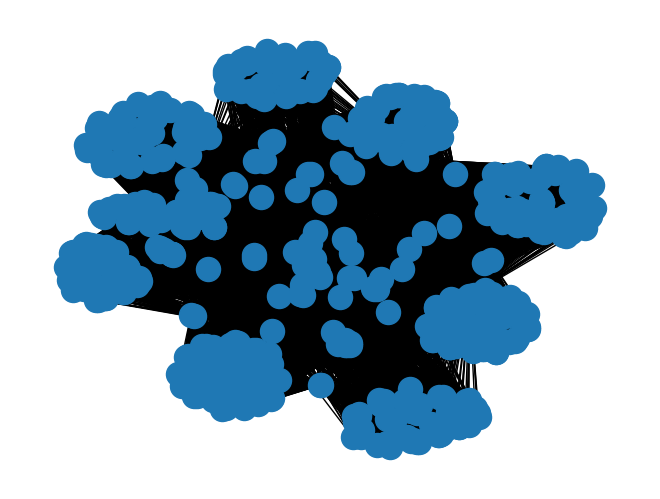

In [ ]:
nx.draw(G)

### 1.4 dsm으로 커뮤니티 나누기

In [ ]:
### 후보 4 ###
### modularity를 평가지표로 두면 될 것 같음

import networkx as nx
from networkx.algorithms import community

communities = community.asyn_fluidc(G, 9, max_iter=100, seed=None)

# 결과 출력
for i, community in enumerate(communities):
    # print(f"Community {i}: {community}")
    
    words_list = []

    for word in community:
      str_word = model_dsm_whole_well.wv.index_to_key[word]
      words_list.append(str_word)
    
    print(f"Community {i} : ", words_list)

Community 0 :  ['개탄', '목숨', '벗어나다', '담배빵', '에서', '한강에', '한다', '지치다', '죽어야', '먹다', '죽어도', '죽는게', '깨지', '유서', '잠에서', '편해지고', '없어지다', '한꺼번에', '자해', '죽다', '번', '살다', '끈', '약을', '충동', '끊다', '살아서', '괜찮다', '아프다', '깨지다', '뭐하나', '살', '세상에서', '없어지고', '뭐', '이유가', '가치가', '사라지고', '사는게', '하나', '현실', '아프게', '죽음', '칼빵', '한강', '긋는다', '떠나고', '도피', '세상을', '않았으면', '뛰어들다', '이제', '세상', '손목', '사라지다', '마렵다', '지친다', '버티다', '마지막', '약', '법', '죽는', '목', '벗어나고', '오지', '매달다', '눈을', '편하다', '이유', '살기', '곳', '높다', '끝내다', '희망이', '도망가다', '그만하다', '목숨을', '가치', '긋다', '목을', '없으면', '낫다', '떠나다', '높은', '뜨지', '내일이', '곳에서', '도망가고', '고통', '그만하고', '방법', '자해)', '고통에서', '멈추다', '자살(또는', '내일', '멈추고', '자살', '고통을']
Community 1 :  ['있다', '다시', '일어난다', '수면장애', '개운하지', '자도자도', '잡', '말똥말똥', '깬다', '생각', '얕게', '못자다', '싶다', '통잠을', '안온다', '잠이', '설친다', '잠을', '깨다', '신생아처럼', '잠들기', '밤을', '꾸벅꾸벅', '오다', '얕다', '잠', '깊게', '눈만', '늦게', '뒤척거리다', '눈으로', '많다', '피곤하다', '밤', '푹', '잠들다', '지새다', '새벽', '수면제', '눈꺼풀', '일어나다', '새다']
Community 2 :  ['움직이다', '쓰지', '

### 1.5 웰니스 데이터 추가해 커뮤니티 나누기

In [ ]:
dsm_whole_well.query("label == -1")

,words,symptoms,label
563,"['제', '감정', '이상하다', '것', '같다', '남편', '만', '보다'...",웰니스,-1
564,"['더', '이상', '내', '감정', '을', '내', '컨트롤', '못']",웰니스,-1
565,"['하루', '종일', '롤러코스터', '타다', '기분', '이에요']",웰니스,-1
566,"['꼭', '롤러코스터', '타다', '것', '같다']",웰니스,-1
567,"['롤러코스터', '타다', '것', '처럼', '기분', '오다', '가다', '...",웰니스,-1
...,...,...,...
5789,"['한숨', '자고', '일어나다', '괜찮다', '자고', '일어나다', '똑같다']",웰니스,-1
5790,"['자고', '나다', '괜찮다', '줄', '알다', '비슷하다']",웰니스,-1
5791,"['지금', '상태', '계속', '안', '좋다']",웰니스,-1
5792,"['게', '제', '마음', '상관없다', '증상', '계속', '나타나다']",웰니스,-1


In [ ]:
only_well_df = dsm_whole_well.query("label == -1").reset_index().iloc[:, 1:]

well = []

for i in range(len(only_well_df)):
  str_list = only_well_df.iloc[i, 0].split("'")
  real_str_list = []

  for strs in str_list:
    if re.search('[가-힣]+', strs):
      real_str_list.append(strs)
  
  well.append(real_str_list)

well
well_list_ = []

for k in range(len(well)):
  lines = well[k]
  for u in range(len(lines)):
    well_list_.append(lines[u])

well_list_
well_word_from = []
well_word_to = []
well_weight = []

similarities_list = []

for word1 in well_list_:
    for word2 in word_list_:
            similarity = model_dsm_whole_well.wv.similarity(word1, word2)
            similarities_list.append(similarity)

            if similarity > 0.5:
              well_word_from.append(model_dsm_whole_well.wv.key_to_index[f'{word1}'])
              well_word_to.append(model_dsm_whole_well.wv.key_to_index[f'{word2}'])
              well_weight.append(similarity)

G_to_add = pd.DataFrame({'word_from' : well_word_from, 'word_to' : well_word_to, 'weight' : well_weight})
G_to_add

[['제',
  '감정',
  '이상하다',
  '것',
  '같다',
  '남편',
  '만',
  '보다',
  '화가',
  '오르다',
  '감정',
  '조절',
  '안되다'],
 ['더', '이상', '내', '감정', '을', '내', '컨트롤', '못'],
 ['하루', '종일', '롤러코스터', '타다', '기분', '이에요'],
 ['꼭', '롤러코스터', '타다', '것', '같다'],
 ['롤러코스터', '타다', '것', '처럼', '기분', '오다', '가다', '해', '요'],
 ['작년', '부터', '감정', '조절', '자다', '안', '되다', '거', '같다'],
 ['예전', '비', '인내심', '너무', '거', '같다'],
 ['더', '이상', '혼자', '서다', '감정', '조절', '을', '못'],
 ['점점', '나', '자신', '을', '컨트롤', '못', '기분', '이야'],
 ['나다', '이르다', '싫다', '내', '마음대로', '안', '돼다'],
 ['정신', '일', '때', '저', '주체', '수', '가다', '없다'],
 ['주체', '안', '돼다'],
 ['이렇게', '쌓이다', '쌓이다', '나중', '확', '터지다', '진짜', '걷다', '잡', '을', '수', '없다'],
 ['근데', '감정', '을', '다스리다', '못', '욱', '하', '기도', '하고'],
 ['순간', '순간', '감정', '조절', '을', '못'],
 ['평소',
  '다른',
  '일',
  '을',
  '때',
  '비슷하다',
  '생각',
  '대로',
  '안되다',
  '화가',
  '나다',
  '그렇다',
  '상황',
  '지속',
  '되다',
  '폭발',
  '버리다'],
 ['예전', '보다', '화', '내다', '게', '과격하다', '거', '같다'],
 ['화가', '안', '참다'],
 ['근데', '다음', '또', '그러면', '또', '화가

In [ ]:
well_list_ = []

for k in range(len(well)):
  lines = well[k]
  for u in range(len(lines)):
    well_list_.append(lines[u])

well_list_

['제',
 '감정',
 '이상하다',
 '것',
 '같다',
 '남편',
 '만',
 '보다',
 '화가',
 '오르다',
 '감정',
 '조절',
 '안되다',
 '더',
 '이상',
 '내',
 '감정',
 '을',
 '내',
 '컨트롤',
 '못',
 '하루',
 '종일',
 '롤러코스터',
 '타다',
 '기분',
 '이에요',
 '꼭',
 '롤러코스터',
 '타다',
 '것',
 '같다',
 '롤러코스터',
 '타다',
 '것',
 '처럼',
 '기분',
 '오다',
 '가다',
 '해',
 '요',
 '작년',
 '부터',
 '감정',
 '조절',
 '자다',
 '안',
 '되다',
 '거',
 '같다',
 '예전',
 '비',
 '인내심',
 '너무',
 '거',
 '같다',
 '더',
 '이상',
 '혼자',
 '서다',
 '감정',
 '조절',
 '을',
 '못',
 '점점',
 '나',
 '자신',
 '을',
 '컨트롤',
 '못',
 '기분',
 '이야',
 '나다',
 '이르다',
 '싫다',
 '내',
 '마음대로',
 '안',
 '돼다',
 '정신',
 '일',
 '때',
 '저',
 '주체',
 '수',
 '가다',
 '없다',
 '주체',
 '안',
 '돼다',
 '이렇게',
 '쌓이다',
 '쌓이다',
 '나중',
 '확',
 '터지다',
 '진짜',
 '걷다',
 '잡',
 '을',
 '수',
 '없다',
 '근데',
 '감정',
 '을',
 '다스리다',
 '못',
 '욱',
 '하',
 '기도',
 '하고',
 '순간',
 '순간',
 '감정',
 '조절',
 '을',
 '못',
 '평소',
 '다른',
 '일',
 '을',
 '때',
 '비슷하다',
 '생각',
 '대로',
 '안되다',
 '화가',
 '나다',
 '그렇다',
 '상황',
 '지속',
 '되다',
 '폭발',
 '버리다',
 '예전',
 '보다',
 '화',
 '내다',
 '게',
 '과격하다',
 '거',
 '같다',
 '화가',
 '안',
 '참다',

In [ ]:
well_word_from = []
well_word_to = []
well_weight = []

similarities_list = []

for word1 in well_list_:
    for word2 in word_list_:
            similarity = model_dsm_whole_well.wv.similarity(word1, word2)
            similarities_list.append(similarity)

            if similarity > 0.5:
              well_word_from.append(model_dsm_whole_well.wv.key_to_index[f'{word1}'])
              well_word_to.append(model_dsm_whole_well.wv.key_to_index[f'{word2}'])
              well_weight.append(similarity)

G_to_add = pd.DataFrame({'word_from' : well_word_from, 'word_to' : well_word_to, 'weight' : well_weight})
G_to_add

,word_from,word_to,weight
0,34,501,0.993585
1,34,560,0.992484
2,34,965,0.993091
3,34,27,0.999758
4,34,537,0.993322
...,...,...,...
7837163,8,89,0.999731
7837164,8,2592,0.789908
7837165,8,2590,0.694320
7837166,8,2589,0.716442


(array([1.760000e+02, 8.000000e+01, 1.200000e+01, 4.000000e+00,
        1.200000e+01, 6.000000e+00, 4.000000e+00, 6.000000e+00,
        4.000000e+00, 4.000000e+00, 6.000000e+00, 1.000000e+01,
        1.000000e+01, 4.000000e+00, 2.000000e+00, 8.000000e+00,
        4.000000e+00, 6.000000e+00, 4.000000e+00, 4.000000e+00,
        6.000000e+00, 2.200000e+01, 4.000000e+01, 2.280000e+02,
        1.930000e+02, 1.000000e+02, 9.000000e+01, 1.680000e+02,
        3.920000e+02, 4.409000e+03, 3.574700e+04, 1.176000e+03,
        5.320000e+02, 3.990000e+02, 5.580000e+02, 3.000000e+03,
        3.749900e+04, 2.010000e+03, 1.983200e+04, 2.139200e+04,
        1.474000e+03, 3.054000e+03, 3.738300e+04, 1.859000e+03,
        1.668000e+03, 3.332700e+04, 8.175000e+03, 1.369500e+04,
        2.747100e+04, 1.070000e+03, 6.820000e+02, 1.259000e+03,
        1.538000e+04, 2.532100e+04, 1.018000e+03, 8.200000e+02,
        1.971000e+03, 3.702200e+04, 5.151000e+03, 9.516000e+03,
        3.165700e+04, 1.331000e+03, 1.24

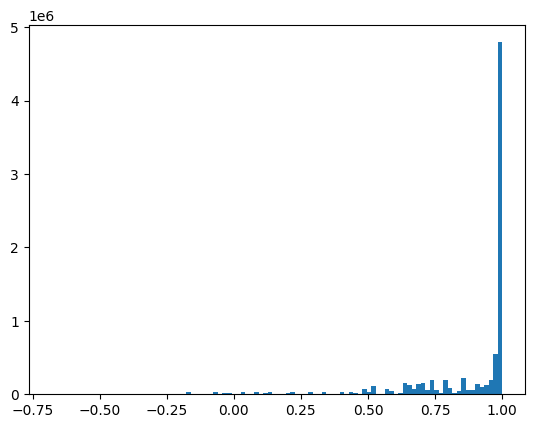

In [ ]:
# threshold 설정위한 히스토그램
plt.hist(similarities_list, bins = 100)

In [ ]:
# 노드 리스트 만들기
well_nodes_li = []

for i in range(2):
  for j in G_to_add.iloc[:, i]:
    well_nodes_li.append(j)

len(list(set(well_nodes_li)))

2419

In [ ]:
# 노드 만들기
G.add_nodes_from(list(set(well_nodes_li)))

In [ ]:
# 엣지 리스트 및 가중치
for i in range(len(G_to_add)):
  from_edge = G_to_add.iloc[i, 0].item()
  to_edge = G_to_add.iloc[i, 1].item()
  weight_ = G_to_add.iloc[i, 2].item()


  G.add_edge(from_edge, to_edge, weight = weight_)

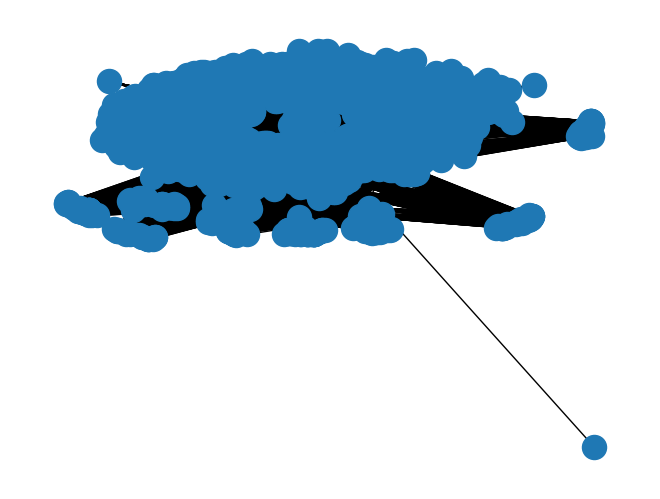

In [ ]:
nx.draw(G)

In [ ]:
import networkx as nx
from networkx.algorithms import community

final_communities = community.asyn_fluidc(G, 9, max_iter=100, seed= 171)


# 결과 출력
for i, community in enumerate(final_communities):
    globals()[f'community_{i}'] = community
    print(f"Community {i}: {community}")

Community 0: {3, 5, 2570, 2572, 16, 19, 2607, 48, 562, 50, 569, 575, 590, 592, 2644, 87, 600, 2647, 2653, 610, 2661, 2663, 105, 2665, 2672, 1138, 2674, 128, 644, 175, 1720, 1721, 1722, 204, 1237, 1249, 231, 1255, 1770, 1259, 1775, 1786, 1793, 259, 1822, 308, 831, 330, 336, 871, 2438, 903, 2440, 2444, 2448, 2449, 1430, 2467, 2468, 2469, 2470, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2481, 2487, 971, 466, 469, 982, 472, 481, 482, 1012, 505, 508, 2557}
Community 1: {1, 1154, 382, 2308, 2437, 389, 2311, 1799, 2441, 1796, 267, 2571, 522, 782, 1803, 403, 1811, 664, 154, 667, 541, 1054, 2463, 288, 1827, 36, 164, 678, 940, 691, 57, 2489, 315, 2491, 447, 2495, 2498, 67, 2499, 198, 1357, 591, 1235, 724, 2645, 2643, 2649, 2650, 2652, 2656, 2659, 740, 1637, 2662, 359, 355, 2664, 2667, 2668, 2670, 2671, 496, 1777, 1778, 2675, 2673, 1781, 2167, 124, 1789, 254, 1791}
Community 2: {0, 11, 17, 18, 20, 21, 22, 25, 26, 27, 28, 29, 31, 32, 34, 35, 39, 40, 41, 43, 46, 51, 54, 59, 60, 66, 68, 69, 71,

### 1.6 community 추정하기

In [ ]:
whole_commu = []

for i in range(9):
  words_list = []

  for word in globals()[f'community_{i}']:
    str_word = model_dsm_whole_well.wv.index_to_key[word]
    words_list.append(str_word)

  whole_commu.append(words_list)

  print(f'community_{i} : ', words_list)

community_0 :  ['안', '없다', '맛을', '거르다', '되다', '다', '미식', '모르다', '터지다', '많이', '식욕', '줄다', '몸무게', '거리', '식탐', '또', '입맛', '헐렁하다', '폭식', '맛', '제어', '불량', '몸', '찌', '빵빵', '몸이', '끼니를', '버리다', '옷', '빠지다', '된다', '안된다', '식욕이', '맞다', '고프다', '땡기다', '주다', '돼지', '배가', '마르다', '소화가', '않는다', '채우다', '안되다', '옷이', '살이', '억지로', '귀찮다', '늘다', '소화', '터진다', '다이어트', '불었다', '뚱뚱하다', '맛이', '모르겠다', '비만', '빵빵하다', '꾸역꾸역', '입맛이', '터졌다', '땡긴다', '거르', '끼니', '음식이', '배를', '헐렁해졌다', '맞지', '제어가', '먹는다', '더부룩하다', '토', '먹기', '입', '굶다', '음식', '배', '찌다', '불다', '치다', '붙다', '먹어버렸다']
community_1 :  ['있다', '지루하다', '때리다', '깜깜', '노잼', '인지', '악', '피곤', '노관심', '덧', '쓰다', '쓰지', '움직이다', '즐겁다', '포기', '그만두다', '부질', '평생', '만나다', '큰일', '지치다', '감흥', '무관심', '졸업', '흥미', '일', '눕다', '행동', '외', '소용', '집', '싫증', '관심', '신', '재미', '시무룩', '무의미', '아무', '무기력', '신경', '퇴사', '의욕', '영장', '피하', '신이', '되라', '만나기', '될대로', '누워', '관심이', '하려', '처지다', '욕구', '욕구가', '에만', '감정', '준다', '일하기', '즐겁지', '집에만', '하기', '가라앉다', '지친다', '움직이기', '감정이', '할수', '하다', '투명인간', '나가다',

In [ ]:
# 171
# 0 : 체중변화
# 1 : 흥미_즐거움감소
# 2 : 자살사고
# 3 : 피로_활력상실
# 4 : 우울기분
# 5 : 사고력_집중력감소
# 6 : 불면_수면과다
# 7 : 무가치감_및_죄책감
# 8 : 초조_지연
체중변화 = whole_commu[0]
흥미_즐거움감소 = whole_commu[1]
자살사고 = whole_commu[2]
피로_활력상실 = whole_commu[3]
우울기분 = whole_commu[4]
사고력_집중력감소 = whole_commu[5]
불면_수면과다 = whole_commu[6]
무가치감_및_죄책감 = whole_commu[7]
초조_지연 = whole_commu[8]

# 새로운 단어 가져와서 분류해보기

## 1.1 데이터 전처리

In [ ]:
df_classification = pd.read_excel('/content/drive/MyDrive/대학원/project/정신건강(우울증, 불안장애) 기반의 의미어 구축.xlsx', header = 1).iloc[:, 1:]
df_classification = df_classification.dropna(how = 'all')
df_classification.iloc[:, 0] = ['우울기분', '우울기분', '우울기분', '우울기분', '흥미_즐거움감소', '흥미_즐거움감소', '흥미_즐거움감소', '체중변화', '체중변화', '불면_수면과다', 
                                '초조_지연', '피로_활력상실', '무가치감_및_죄책감', '사고력_집중력감소', '사고력_집중력감소', '무가치감_및_죄책감', '절망감']

df_classification

,핵심증상,임상 키워드,키워드 연관 표현
0,우울기분,"우울, 침울, 멍하다, 무기력, 의욕감소, \n불면, 흥미 상실, \n불안, 식욕부...",머리가 짖눌러지는 느낌 / 머리가 맑지 않다
6,우울기분,"슬프다, 속상하다, \n눈물, 울다, 죄책감, \n그립다, 연민, 서럽다, 비참, ...",매일 슬프고 재미없다는 생각 / 하루종일 울적하다 / 이유없이 눈물이 많이 난다 /...
17,우울기분,"외롭다, 쓸쓸, 무의미, 적적, 울적하다, 고단, \n외톨이, 고독감, \n겉돌다",외롭다 / 쓸쓸하다 / 외로움을 잘 탄다 / \n친구들과 어울리고 집에오면 외롭다
20,우울기분,"화, 원망, 불만, 미운, 연민, 분노, 증오, \n허망",원망스럽다 / 속앓이 / 화 / 참을 수 없다 / \n억압하고 살아왔다 / 늘 내...
22,흥미_즐거움감소,"흥미 감소, \n즐거움 감소, 무기력, 괴롭다, \n의욕 없다, 귀찮다, \n낙없다...",흥이 안난다 / 재미가 없다 / 쳇바퀴 도는 것 같은 일상/ 사는게 재미가 없다 /...
41,흥미_즐거움감소,"감정적 마비, 독단, \n억압, 막말, 독선, \n멋대로, 갈등",혼자 생각에 빠져있을 때가 많다 / 거의 말없이 지냈다 / 혼잣말을 할 때가 있다...
48,흥미_즐거움감소,"상실, 공허, 허무, \n무력감, 무가치, 허탈, 무의미, 자괴감, \n패배감, 외...",매사에 의욕이 없다 / 매일 의욕이 없다 / 이유없는 무기력감 / 마음이 무겁고 무...
53,체중변화,"식욕 감소, 체중 감소, 입맛 감소, 살 빠지다, 못먹다, 식사량 감소, 무기력, ...",식욕없다 / 위가 아프다 / 하루에 한 끼 먹는다 / 식욕이 감소하여 체중도 감소 ...
58,체중변화,"폭식, 체중 증가, \n살찌다, 과체중, \n과식증",예전보다 자꾸 음식이 더 먹고 싶어진다 / 허겁지겁 / 폭식증 / 기분이 울적하면 ...
65,불면_수면과다,"불면, 수면시간 감소, 수면장애, 무기력, \n설치다, 잠 안오다, \n얕게 자다,...",하루종일 잔다 /밤에 8-10시간 낮에 4시간 잠을 잔다/잠은 평소보다 많이 늘었는...


In [ ]:
for i in range(len(df_classification)):
  keywords = df_classification.iloc[i, 1]
  words_li = []

  for words in keywords.split(", "):
    if '\n' in words:
      words_li.append(words[1:].strip())

    else:
      words_li.append(words.strip())

  df_classification.iloc[i, 1] = words_li

df_classification

,핵심증상,임상 키워드,키워드 연관 표현
0,우울기분,"[우울, 침울, 멍하다, 무기력, 의욕감소, 불면, 흥미 상실, 불안, 식욕부진, ...",머리가 짖눌러지는 느낌 / 머리가 맑지 않다
6,우울기분,"[슬프다, 속상하다, 눈물, 울다, 죄책감, 그립다, 연민, 서럽다, 비참, 안타깝...",매일 슬프고 재미없다는 생각 / 하루종일 울적하다 / 이유없이 눈물이 많이 난다 /...
17,우울기분,"[외롭다, 쓸쓸, 무의미, 적적, 울적하다, 고단, 외톨이, 고독감, 겉돌다]",외롭다 / 쓸쓸하다 / 외로움을 잘 탄다 / \n친구들과 어울리고 집에오면 외롭다
20,우울기분,"[화, 원망, 불만, 미운, 연민, 분노, 증오, 허망]",원망스럽다 / 속앓이 / 화 / 참을 수 없다 / \n억압하고 살아왔다 / 늘 내...
22,흥미_즐거움감소,"[흥미 감소, 즐거움 감소, 무기력, 괴롭다, 의욕 없다, 귀찮다, 낙없다, 허무,...",흥이 안난다 / 재미가 없다 / 쳇바퀴 도는 것 같은 일상/ 사는게 재미가 없다 /...
41,흥미_즐거움감소,"[감정적 마비, 독단, 억압, 막말, 독선, 멋대로, 갈등]",혼자 생각에 빠져있을 때가 많다 / 거의 말없이 지냈다 / 혼잣말을 할 때가 있다...
48,흥미_즐거움감소,"[상실, 공허, 허무, 무력감, 무가치, 허탈, 무의미, 자괴감, 패배감, 외롭다,...",매사에 의욕이 없다 / 매일 의욕이 없다 / 이유없는 무기력감 / 마음이 무겁고 무...
53,체중변화,"[식욕 감소, 체중 감소, 입맛 감소, 살 빠지다, 못먹다, 식사량 감소, 무기력,...",식욕없다 / 위가 아프다 / 하루에 한 끼 먹는다 / 식욕이 감소하여 체중도 감소 ...
58,체중변화,"[폭식, 체중 증가, 살찌다, 과체중, 과식증]",예전보다 자꾸 음식이 더 먹고 싶어진다 / 허겁지겁 / 폭식증 / 기분이 울적하면 ...
65,불면_수면과다,"[불면, 수면시간 감소, 수면장애, 무기력, 설치다, 잠 안오다, 얕게 자다, 몽롱...",하루종일 잔다 /밤에 8-10시간 낮에 4시간 잠을 잔다/잠은 평소보다 많이 늘었는...


In [ ]:
for i in range(len(df_classification)):
  keywords = df_classification.iloc[i, 2]
  ex_list = []

  for ex in keywords.split("/"):
    if '\n' in ex:
      x = re.sub("\n", "", ex)
      ex_list.append(x.strip())

    else:
      ex_list.append(ex.strip())

  df_classification.iloc[i, 2] = ex_list

df_classification

,핵심증상,임상 키워드,키워드 연관 표현
0,우울기분,"[우울, 침울, 멍하다, 무기력, 의욕감소, 불면, 흥미 상실, 불안, 식욕부진, ...","[머리가 짖눌러지는 느낌, 머리가 맑지 않다]"
6,우울기분,"[슬프다, 속상하다, 눈물, 울다, 죄책감, 그립다, 연민, 서럽다, 비참, 안타깝...","[매일 슬프고 재미없다는 생각, 하루종일 울적하다, 이유없이 눈물이 많이 난다, 며..."
17,우울기분,"[외롭다, 쓸쓸, 무의미, 적적, 울적하다, 고단, 외톨이, 고독감, 겉돌다]","[외롭다, 쓸쓸하다, 외로움을 잘 탄다, 친구들과 어울리고 집에오면 외롭다]"
20,우울기분,"[화, 원망, 불만, 미운, 연민, 분노, 증오, 허망]","[원망스럽다, 속앓이, 화, 참을 수 없다, 억압하고 살아왔다, 늘 내가 참고 지내..."
22,흥미_즐거움감소,"[흥미 감소, 즐거움 감소, 무기력, 괴롭다, 의욕 없다, 귀찮다, 낙없다, 허무,...","[흥이 안난다, 재미가 없다, 쳇바퀴 도는 것 같은 일상, 사는게 재미가 없다, 사..."
41,흥미_즐거움감소,"[감정적 마비, 독단, 억압, 막말, 독선, 멋대로, 갈등]","[혼자 생각에 빠져있을 때가 많다, 거의 말없이 지냈다, 혼잣말을 할 때가 있다, ..."
48,흥미_즐거움감소,"[상실, 공허, 허무, 무력감, 무가치, 허탈, 무의미, 자괴감, 패배감, 외롭다,...","[매사에 의욕이 없다, 매일 의욕이 없다, 이유없는 무기력감, 마음이 무겁고 무기력..."
53,체중변화,"[식욕 감소, 체중 감소, 입맛 감소, 살 빠지다, 못먹다, 식사량 감소, 무기력,...","[식욕없다, 위가 아프다, 하루에 한 끼 먹는다, 식욕이 감소하여 체중도 감소, 체..."
58,체중변화,"[폭식, 체중 증가, 살찌다, 과체중, 과식증]","[예전보다 자꾸 음식이 더 먹고 싶어진다, 허겁지겁, 폭식증, 기분이 울적하면 식욕..."
65,불면_수면과다,"[불면, 수면시간 감소, 수면장애, 무기력, 설치다, 잠 안오다, 얕게 자다, 몽롱...","[하루종일 잔다, 밤에 8-10시간 낮에 4시간 잠을 잔다, 잠은 평소보다 많이 늘..."


## 1.2 성능보기

In [ ]:
df_classification = pd.read_csv('/content/drive/MyDrive/대학원/project/df_classification.csv').iloc[:, 1:]

In [ ]:
df_classification.iloc[:, [0, 2]]

,핵심증상,키워드 연관 표현
0,우울기분,"['머리가 짖눌러지는 느낌', '머리가 맑지 않다']"
1,우울기분,"['매일 슬프고 재미없다는 생각', '하루종일 울적하다', '이유없이 눈물이 많이 ..."
2,우울기분,"['외롭다', '쓸쓸하다', '외로움을 잘 탄다', '친구들과 어울리고 집에오면 외..."
3,우울기분,"['원망스럽다', '속앓이', '화', '참을 수 없다', '억압하고 살아왔다', ..."
4,흥미_즐거움감소,"['흥이 안난다', '재미가 없다', '쳇바퀴 도는 것 같은 일상', '사는게 재미..."
5,흥미_즐거움감소,"['혼자 생각에 빠져있을 때가 많다', '거의 말없이 지냈다', '혼잣말을 할 때가..."
6,흥미_즐거움감소,"['매사에 의욕이 없다', '매일 의욕이 없다', '이유없는 무기력감', '마음이 ..."
7,체중변화,"['식욕없다', '위가 아프다', '하루에 한 끼 먹는다', '식욕이 감소하여 체중..."
8,체중변화,"['예전보다 자꾸 음식이 더 먹고 싶어진다', '허겁지겁', '폭식증', '기분이 ..."
9,불면_수면과다,"['하루종일 잔다', '밤에 8-10시간 낮에 4시간 잠을 잔다', '잠은 평소보다..."


In [ ]:
sent_label_list = []
sentences_list = []

for i, lines in enumerate(df_classification.iloc[:, 2]):
  sentces = lines[1:-1].split(", ")
  
  for sent in sentces:
    if sent:
      sentences_list.append(sent[1:-1])
      sent_label_list.append(df_classification.iloc[i, 0])

In [ ]:
classifi_df = pd.DataFrame({'label' : sent_label_list, 'sentence' : sentences_list})
classifi_df

,label,sentence
0,우울기분,머리가 짖눌러지는 느낌
1,우울기분,머리가 맑지 않다
2,우울기분,매일 슬프고 재미없다는 생각
3,우울기분,하루종일 울적하다
4,우울기분,이유없이 눈물이 많이 난다
...,...,...
185,절망감,이제와서 뭘 새로 할수 있나 하는 생각
186,절망감,받아들이기도 힘들고
187,절망감,지원을 했었는데 그게 떨어지면서 절망
188,절망감,거절을 당하자 절망적인 기분


In [ ]:
classifi_df.to_csv('/content/drive/MyDrive/대학원/project/classifi_df.csv')

In [ ]:
c_df = classifi_df.query("label != '절망감'")
c_df

,label,sentence
0,우울기분,머리가 짖눌러지는 느낌
1,우울기분,머리가 맑지 않다
2,우울기분,매일 슬프고 재미없다는 생각
3,우울기분,하루종일 울적하다
4,우울기분,이유없이 눈물이 많이 난다
...,...,...
174,무가치감_및_죄책감,다른사람에게 좋은 사람으로 인식되고 싶은데 그러지 못하니까 속상하다
175,무가치감_및_죄책감,어쩔수 없이 내가 하고싶지 않은 일을 하고 있다는 느낌
176,무가치감_및_죄책감,내가 살고싶은대로 살고있지 못하는 것에대한 속상함아무도 자신을 사랑하지 않는 것 같다
177,무가치감_및_죄책감,이전에 내 모습이 없어진 것 같다


In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 KB 44.3 MB/s eta 0:00:00


In [ ]:
# 체중변화 = whole_commu[0]
# 흥미_즐거움감소 = whole_commu[1]
# 자살사고 = whole_commu[2]
# 피로_활력상실 = whole_commu[3]
# 우울기분 = whole_commu[4]
# 사고력_집중력감소 = whole_commu[5]
# 불면_수면과다 = whole_commu[6]
# 무가치감_및_죄책감 = whole_commu[7]
# 초조_지연 = whole_commu[8]

import re
from konlpy.tag import *

pred_list = []

for i in range(len(c_df)):
  체중변화_n = 0
  흥미_즐거움감소_n = 0
  자살사고_n = 0
  피로_활력상실_n = 0
  우울기분_n = 0
  사고력_집중력감소_n = 0
  불면_수면과다_n = 0
  무가치감_및_죄책감_n = 0
  초조_지연_n = 0

  sent = c_df.iloc[i, 1]

  data = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', sent)

  # 불용어 정의
  stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

  okt = Okt()

  tokenized_sentence = okt.morphs(data, stem=True) # 토큰화
  stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거

  for words_ in stopwords_removed_sentence:
    if words_ in 체중변화:
      체중변화_n += 1
    elif words_ in 흥미_즐거움감소:
      흥미_즐거움감소_n += 1
    elif words in 자살사고:
      자살사고_n += 1
    elif words_ in 피로_활력상실:
      피로_활력상실_n += 1
    elif words_ in 우울기분:
      우울기분_n += 1
    elif words_ in 사고력_집중력감소:
      사고력_집중력감소_n += 1
    elif words_ in 불면_수면과다:
      불면_수면과다_n += 1
    elif words_ in 무가치감_및_죄책감:
      무가치감_및_죄책감_n += 1
    elif words_ in 초조_지연:
      초조_지연_n += 1

  point_list = [체중변화_n, 흥미_즐거움감소_n, 자살사고_n, 피로_활력상실_n, 우울기분_n, 사고력_집중력감소_n, 불면_수면과다_n, 무가치감_및_죄책감_n, 초조_지연_n]

  m = max(point_list)
  pred_li = []

  if m != 0:
    point_idx = [i for i, v in enumerate(point_list) if v == m]
    for idx in point_idx:
      if idx == 0:
        pred_li.append('체중변화')
      elif idx == 1:
        pred_li.append('흥미_즐거움감소')
      elif idx == 2:
        pred_li.append('자살사고')
      elif idx == 3:
        pred_li.append('피로_활력상실')
      elif idx == 4:
        pred_li.append('우울기분')
      elif idx == 5:
        pred_li.append('사고력_집중력감소')
      elif idx == 6:
        pred_li.append('불면_수면과다')
      elif idx == 7:
        pred_li.append('무가치감_및_죄책감')
      elif idx == 8:
        pred_li.append('초조_지연')

  else:
    pred_li.append('예측불가')

  pred_list.append(pred_li)

pred_list

[['우울기분', '사고력_집중력감소'],
 ['우울기분', '사고력_집중력감소'],
 ['우울기분', '사고력_집중력감소'],
 ['우울기분'],
 ['체중변화', '우울기분', '사고력_집중력감소'],
 ['우울기분'],
 ['피로_활력상실', '우울기분'],
 ['무가치감_및_죄책감'],
 ['우울기분'],
 ['우울기분'],
 ['예측불가'],
 ['불면_수면과다'],
 ['흥미_즐거움감소', '우울기분', '불면_수면과다'],
 ['초조_지연'],
 ['예측불가'],
 ['무가치감_및_죄책감'],
 ['체중변화', '우울기분', '초조_지연'],
 ['예측불가'],
 ['피로_활력상실'],
 ['우울기분'],
 ['우울기분'],
 ['예측불가'],
 ['체중변화', '사고력_집중력감소'],
 ['체중변화', '흥미_즐거움감소'],
 ['초조_지연'],
 ['체중변화', '흥미_즐거움감소', '무가치감_및_죄책감'],
 ['무가치감_및_죄책감'],
 ['체중변화', '초조_지연'],
 ['체중변화', '초조_지연'],
 ['체중변화', '초조_지연'],
 ['체중변화', '초조_지연'],
 ['우울기분'],
 ['흥미_즐거움감소'],
 ['피로_활력상실', '우울기분'],
 ['흥미_즐거움감소', '우울기분'],
 ['흥미_즐거움감소'],
 ['초조_지연'],
 ['체중변화'],
 ['흥미_즐거움감소', '우울기분', '불면_수면과다'],
 ['체중변화', '흥미_즐거움감소', '우울기분', '초조_지연'],
 ['흥미_즐거움감소', '우울기분', '초조_지연'],
 ['체중변화'],
 ['체중변화', '사고력_집중력감소', '불면_수면과다', '무가치감_및_죄책감'],
 ['피로_활력상실', '초조_지연'],
 ['흥미_즐거움감소', '무가치감_및_죄책감'],
 ['체중변화', '흥미_즐거움감소', '무가치감_및_죄책감'],
 ['우울기분', '불면_수면과다', '무가치감_및_죄책감'],
 ['피로_활력상실', '우울기분', '무가치감_및_죄책감'],

In [ ]:
c_df['predicted_label'] = pred_list
c_df

<ipython-input-231-c261d3258938>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_df['predicted_label'] = pred_list


,label,sentence,predicted_label
0,우울기분,머리가 짖눌러지는 느낌,"[우울기분, 사고력_집중력감소]"
1,우울기분,머리가 맑지 않다,"[우울기분, 사고력_집중력감소]"
2,우울기분,매일 슬프고 재미없다는 생각,"[우울기분, 사고력_집중력감소]"
3,우울기분,하루종일 울적하다,[우울기분]
4,우울기분,이유없이 눈물이 많이 난다,"[체중변화, 우울기분, 사고력_집중력감소]"
...,...,...,...
174,무가치감_및_죄책감,다른사람에게 좋은 사람으로 인식되고 싶은데 그러지 못하니까 속상하다,[무가치감_및_죄책감]
175,무가치감_및_죄책감,어쩔수 없이 내가 하고싶지 않은 일을 하고 있다는 느낌,[우울기분]
176,무가치감_및_죄책감,내가 살고싶은대로 살고있지 못하는 것에대한 속상함아무도 자신을 사랑하지 않는 것 같다,"[무가치감_및_죄책감, 초조_지연]"
177,무가치감_및_죄책감,이전에 내 모습이 없어진 것 같다,[초조_지연]


In [ ]:
for i, m in enumerate(c_df['predicted_label']):
  c_df['predicted_label'][i] = str(m)[1:-1]

c_df

<ipython-input-237-82a03d70dac9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_df['predicted_label'][i] = str(m)[1:-1]


,label,sentence,predicted_label
0,우울기분,머리가 짖눌러지는 느낌,"'우울기분', '사고력_집중력감소'"
1,우울기분,머리가 맑지 않다,"'우울기분', '사고력_집중력감소'"
2,우울기분,매일 슬프고 재미없다는 생각,"'우울기분', '사고력_집중력감소'"
3,우울기분,하루종일 울적하다,'우울기분'
4,우울기분,이유없이 눈물이 많이 난다,"'체중변화', '우울기분', '사고력_집중력감소'"
...,...,...,...
174,무가치감_및_죄책감,다른사람에게 좋은 사람으로 인식되고 싶은데 그러지 못하니까 속상하다,'무가치감_및_죄책감'
175,무가치감_및_죄책감,어쩔수 없이 내가 하고싶지 않은 일을 하고 있다는 느낌,'우울기분'
176,무가치감_및_죄책감,내가 살고싶은대로 살고있지 못하는 것에대한 속상함아무도 자신을 사랑하지 않는 것 같다,"'무가치감_및_죄책감', '초조_지연'"
177,무가치감_및_죄책감,이전에 내 모습이 없어진 것 같다,'초조_지연'


In [ ]:
c_df.query('label == "우울기분"')

,label,sentence,predicted_label
0,우울기분,머리가 짖눌러지는 느낌,"'우울기분', '사고력_집중력감소'"
1,우울기분,머리가 맑지 않다,"'우울기분', '사고력_집중력감소'"
2,우울기분,매일 슬프고 재미없다는 생각,"'우울기분', '사고력_집중력감소'"
3,우울기분,하루종일 울적하다,'우울기분'
4,우울기분,이유없이 눈물이 많이 난다,"'체중변화', '우울기분', '사고력_집중력감소'"
5,우울기분,며칠이고 하염없이 운다,'우울기분'
6,우울기분,몇시간씩 운다,"'피로_활력상실', '우울기분'"
7,우울기분,눈물이 아무때나 난다,'무가치감_및_죄책감'
8,우울기분,매일 운다,'우울기분'
9,우울기분,외롭다,'우울기분'


In [ ]:
print(len(c_df.query('label == "흥미_즐거움감소"')))
c_df.query('label == "흥미_즐거움감소"')

In [ ]:
c_df.query('label == "체중변화"')

,label,sentence,predicted_label
62,체중변화,식욕없다,'체중변화'
63,체중변화,위가 아프다,'피로_활력상실'
64,체중변화,하루에 한 끼 먹는다,'피로_활력상실'
65,체중변화,식욕이 감소하여 체중도 감소,'체중변화'
66,체중변화,체중이 빠지고 머리카락도 많이 빠졌다,'체중변화'
67,체중변화,체중이 빠지고 생리는 6개월 째 안하는 중,'체중변화'
68,체중변화,이유없이 살이 빠지고,'체중변화'
69,체중변화,식욕이 너무 없어서 식욕 촉진제를 먹었다,'체중변화'
70,체중변화,한끼에 반공기정도,'예측불가'
71,체중변화,죽 먹고 있다,'피로_활력상실'


In [ ]:
c_df.query('label == "불면_수면과다"')

,label,sentence,predicted_label
83,불면_수면과다,하루종일 잔다,'불면_수면과다'
84,불면_수면과다,밤에 8-10시간 낮에 4시간 잠을 잔다,'불면_수면과다'
85,불면_수면과다,잠은 평소보다 많이 늘었는데 잠을 자고 나도 기분이 좋지 않다,'불면_수면과다'
86,불면_수면과다,하루종일 자고 싶다,'불면_수면과다'
87,불면_수면과다,잠만 자고 싶어서 낮에 약을 먹고 하루에 15시간 정도 잔다밤에 4-5시간 정도 잔다,'불면_수면과다'
88,불면_수면과다,새벽에 일찍 깬다,'불면_수면과다'
89,불면_수면과다,낮에 피곤하다,'불면_수면과다'
90,불면_수면과다,하루 2-3시간 정도밖에 자지 못하고,"'무가치감_및_죄책감', '초조_지연'"
91,불면_수면과다,약 먹고 한두시간 잤는데 이젠 아예 잠에 못 들때가 많다,'불면_수면과다'
92,불면_수면과다,수면제를 10알 가량 먹어도 3시간 이상 수면을 지속하기 어려워,"'피로_활력상실', '불면_수면과다'"


In [ ]:
c_df.query('label == "초조_지연"')

,label,sentence,predicted_label
103,초조_지연,늘 쫓기는 느낌,'우울기분'
104,초조_지연,불편감잘 모르겠다,"'체중변화', '우울기분'"
105,초조_지연,나 자신을 주체할 수 없다공격적이 된다,"'체중변화', '무가치감_및_죄책감'"
106,초조_지연,짜증이 늘었다,"'체중변화', '초조_지연'"
107,초조_지연,갑자기 짜증이 난다,"'사고력_집중력감소', '초조_지연'"
108,초조_지연,괜히 짜증이 난다,"'사고력_집중력감소', '초조_지연'"
109,초조_지연,매사가 다 짜증난다,"'체중변화', '피로_활력상실'"
110,초조_지연,신경질이 늘었다스트레스 받으면서 기복 심해진다,"'체중변화', '무가치감_및_죄책감', '초조_지연'"
111,초조_지연,,'예측불가'


In [ ]:
c_df.query('label == "피로_활력상실"')

,label,sentence,predicted_label
112,피로_활력상실,늘 피곤하고 무기력하다,'불면_수면과다'
113,피로_활력상실,아무것도 못할 정도로 피곤한다,"'흥미_즐거움감소', '불면_수면과다', '무가치감_및_죄책감', '초조_지연'"
114,피로_활력상실,소진됐다,'초조_지연'
115,피로_활력상실,건드려도 반응이 없을 정도로 힘이없다,'체중변화'
116,피로_활력상실,기진맥진하다,'예측불가'
117,피로_활력상실,쉬고싶다,'초조_지연'
118,피로_활력상실,슬럼프,'예측불가'
119,피로_활력상실,몸을 마음대로 움직이기 힘든 느낌,"'체중변화', '흥미_즐거움감소', '우울기분', '무가치감_및_죄책감'"


In [ ]:
c_df.query('label == "무가치감_및_죄책감"')

,label,sentence,predicted_label
120,무가치감_및_죄책감,너무 힘들고 지쳐서 그만두고싶다.,'흥미_즐거움감소'
121,무가치감_및_죄책감,이렇게 살면 뭐하나,'예측불가'
122,무가치감_및_죄책감,전부 손을 놓게 된다,"'체중변화', '피로_활력상실'"
123,무가치감_및_죄책감,사는게 허무하다,'무가치감_및_죄책감'
124,무가치감_및_죄책감,모든것을 포기한 느낌,"'흥미_즐거움감소', '우울기분', '초조_지연'"
125,무가치감_및_죄책감,기분이 가라앉으면 다 필요없다는 생각이 든다,"'체중변화', '흥미_즐거움감소', '우울기분', '사고력_집중력감소'"
126,무가치감_및_죄책감,나른하다,'초조_지연'
127,무가치감_및_죄책감,온 몸에 힘이없다,'체중변화'
128,무가치감_및_죄책감,말하는 것도 힘들다,'초조_지연'
129,무가치감_및_죄책감,의미가 없다 지쳤다,"'체중변화', '흥미_즐거움감소'"


In [ ]:
c_df.query('label == "사고력_집중력감소"')

,label,sentence,predicted_label
139,사고력_집중력감소,일에 대한 집중이 어렵다,"'흥미_즐거움감소', '사고력_집중력감소', '불면_수면과다'"
140,사고력_집중력감소,머리가 멍하고 집중도 잘 안된다,'사고력_집중력감소'
141,사고력_집중력감소,주의력이 떨어지는 것 같다,'초조_지연'
142,사고력_집중력감소,이해력이 떨어진 것 같다,'초조_지연'
143,사고력_집중력감소,판단력이 서지 않는다,'우울기분'
144,사고력_집중력감소,정리가 되지 않는다,"'체중변화', '우울기분', '사고력_집중력감소'"
145,사고력_집중력감소,매우 혼란스럽다,'초조_지연'
146,사고력_집중력감소,머릿속이 정리가 안된다,'사고력_집중력감소'
147,사고력_집중력감소,제정신이 아니다,'사고력_집중력감소'
148,사고력_집중력감소,마음이 정리가 안된다,"'체중변화', '우울기분', '사고력_집중력감소'"


In [ ]:
c_df.label.unique()

array(['우울기분', '흥미_즐거움감소', '체중변화', '불면_수면과다', '초조_지연', '피로_활력상실',
       '무가치감_및_죄책감', '사고력_집중력감소'], dtype=object)

# 예비 코드

## 노드 레이블 불러오려고 했던 코드

In [ ]:
dsm_word_well[:3]

,words,symptoms,label
0,"['가망', '없다']",우울기분,0
1,"['가슴', '아프다']",우울기분,0
2,"['가치', '없다']",우울기분,0


In [ ]:
#### 단어의 레이블 뽑기 ####
import re
# dsm만 남기기
dsm_word_df = dsm_word_well.query("label != -1")
dsm_word_df.reset_index(inplace = True)
dsm_word_df = dsm_word_df.iloc[:, 1:]

# 레이블 dict 만들기
label_d_li = []


# 데이터 프레임 안에 있는 리스트 str에서 다시 복구하기
d_w_list = []

for i in range(len(dsm_word_df)):
  str_list = dsm_word_df.iloc[i, 0].split("'")
  real_str_list = []

  for strs in str_list:
    if re.search('[가-힣]+', strs):
      real_str_list.append(strs)
  
  d_w_list.append(real_str_list)

# 복구한 리스트로 레이블 딕셔너리 만들기
for i in range(len(d_w_list)):
  words_ = d_w_list[i]
  symp = dsm_word_df.loc[i, 'label']

  for word in words_:
    dict_to_add = {}
    dict_to_add[word] = symp
    label_d_li.append(dict_to_add)


#### 데이터 프레임으로 만들기 ####
label_keys = []
label_values = []

for l in label_d_li:
  label_keys.append([x for x in l.keys()][0])

  if len([x for x in l.values()]) == 1:
    label_values.append([x for x in l.values()][0])
  else:
    label_values.append([x for x in l.values()][:])

label_df_word = pd.DataFrame({'vocab' : label_keys, 'label_idx' : label_values})
label_df_word

,vocab,label_idx
0,가망,0
1,없다,0
2,가슴,0
3,아프다,0
4,가치,0
...,...,...
679,칼빵,8
680,한강,8
681,뛰어들다,8
682,현실,8


In [ ]:
# label propagation을 위한 레이블 설정
node_labels = {}

for word in label_df_word.vocab:
  # 해당 단어의 인덱스
  node_idx = model_dsm_word_well.wv.key_to_index[word]

  # 해당 단어의 레이블을 뽑아내기위한 데이터프레임
  lbl_df = label_df_word.query(f"vocab == '{word}'")

  # 레이블 리스트 추출
  node_lbl = list(set(lbl_df.label_idx))

  # 추가할 dict 만들기
  temp_dict = {}
  temp_dict['label'] = node_lbl

  # 레이블 dict에 추가
  node_labels[node_idx] = temp_dict

node_labels

{2271: {'label': [0, 6]},
 5: {'label': [0, 1, 2, 5, 6, 8]},
 144: {'label': [0]},
 94: {'label': [0, 8]},
 975: {'label': [0, 8]},
 731: {'label': [0]},
 4: {'label': [0, 4]},
 2: {'label': [0, 4, 6]},
 512: {'label': [0]},
 1461: {'label': [0]},
 2399: {'label': [0]},
 384: {'label': [0]},
 2400: {'label': [0]},
 75: {'label': [0, 5]},
 478: {'label': [0, 1]},
 295: {'label': [0, 5, 6]},
 216: {'label': [0]},
 19: {'label': [0, 1, 2, 3, 5, 7]},
 1211: {'label': [0]},
 728: {'label': [0, 1, 5, 6]},
 2401: {'label': [0]},
 614: {'label': [0]},
 2402: {'label': [0]},
 2403: {'label': [0]},
 296: {'label': [0]},
 2404: {'label': [0]},
 168: {'label': [0]},
 45: {'label': [0]},
 920: {'label': [0]},
 278: {'label': [0]},
 77: {'label': [0]},
 89: {'label': [0]},
 100: {'label': [0]},
 112: {'label': [0]},
 1194: {'label': [0]},
 506: {'label': [0]},
 2409: {'label': [0]},
 686: {'label': [0]},
 106: {'label': [0]},
 485: {'label': [0, 8]},
 2412: {'label': [0]},
 0: {'label': [0, 2, 3, 4,